# LCPB 20-21 Exercise 4: data visualization with t-SNE and clustering with DBSCAN
## RandomGroup
### Alessandro Casalino 2015122
### Michele M. Crudele 2021858
### Sabrina Giorgetti 2013375
### Daniele Mellino 2013373

## Overview

1. [Part 1](#p1) <br>
   1.1 [Data Visualization with t-SNE](#p11) 
   - [2D t-SNE with random initialization](#2dtsna) <br>
   - [2D t-SNE with PCA initialization](#2dtsnepca) <br>
   - [3D t-SNE with random initialization ](#3d) <br>
   - [3D t-SNE with PCA initialization](#3dpca) <br> <br>
   1.2 [DBSCAN ](#p13) <br> <br>
2. [Part 2](#p2) <br>
    2.1 [t-SNE](#tsne2) <br>
    2.2 [Sorted all minimum distances to first neighbors with plot](#neigh) <br>
    2.3 [DBSCAN applied the 36-dimensional bit data](#dbscan36) <br>
    2.4 [DBSCAN applied to the data projected to 2D by t-SNE](#ds2dtsne) <br>

In [7]:
use_colab = False
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [8]:
import matplotlib.pyplot as plt 
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 

import os
import pandas as pd
from time import time
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

# Part 1 <a id='p1'></a>

The data file used in this first part of the notebook contains high dimensional data (d=5 in this case) with embedded manifolds as those in the figures below, which represent three clusters with a linear closed structure. Given N data points, the first 10% belongs to cluster “0” (red), the next 30% to cluster “1” (green) and the last 60% to cluster “2” (blue).

In [3]:
if use_colab:
    filename = "../content/drive/MyDrive/lcpb/ex4/data_t-SNE_310101_d5_R100_e1_N800.dat"
else:
    filename = "data_t-SNE_310101_d5_R100_e1_N800.dat"
df = pd.read_table(filename, sep="\t", header=None)
print('Shape of the dataframe:', df.shape)
df

Shape of the dataframe: (800, 5)


0      1      2       3      4
0    -83065  29521  68815 -100340 -29235
1   -110304  38545  68519 -115776 -46287
2    -88908  31418  69174 -107023 -30120
3    -99298  32751  71580 -113674 -38766
4    -77225  29431  64216  -95754 -28018
..      ...    ...    ...     ...    ...
795   81024  53467  46739   54310  19020
796  -76420 -65897 -59331  -46679 -11939
797  -40830 -60967 -76134   -3094  -8516
798   -8663  34856  72689  -48530   -115
799   15383 -31370 -50938   33971   8427

[800 rows x 5 columns]

In [4]:
data = np.loadtxt(filename, delimiter='\t', dtype=np.int32)

In [5]:
perc0 = 0.1 # red
perc1 = 0.3 # green
perc2 = 0.6 # blue
N = data.shape[0]
N0 = int(perc0*N)
N1 = int(perc1*N)
N2 = N - N0 - N1

data0 = data[:N0]
data1 = data[N0:N0+N1]
data2 = data[N0+N1:]

labels = np.zeros(N)
labels[N0:N0+N1] = 1
labels[N0+N1:] = 2

red = (labels == 0)
green = (labels == 1)
blue = (labels == 2)

In [6]:
def plot_dim(data, i=1, j=2, k=3, frac1=0.1, frac2=0.3, angle1=60, angle2=20):
    #angle1 is the elevation, angle2 the xy angle
    dim=len(data[0])
    if dim<i or dim<j or dim<k:
        print("Dimensional error")
        return
    
    x = np.array(data[:,i])
    y = np.array(data[:,j])
    z = np.array(data[:,k])
    
    N  = len(x)
    N1 = int(N*frac1)
    N2 = int(N*frac2)
    N3 = int(N*(1-frac1-frac2))
    
    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_title("Original data in their first three dimensions")
    
    x1 = x[:N1]
    x2 = x[N1:(N1+N2)]
    x3 = x[(N1+N2):]
    y1 = y[:N1]
    y2 = y[N1:(N1+N2)]
    y3 = y[(N1+N2):]
    z1 = z[:N1]
    z2 = z[N1:(N1+N2)]
    z3 = z[(N1+N2):]
    
    ax.scatter(x3,y3,z3, c='b')
    ax.scatter(x1,y1,z1, c='r')
    ax.scatter(x2,y2,z2, c='g')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(angle1, angle2)

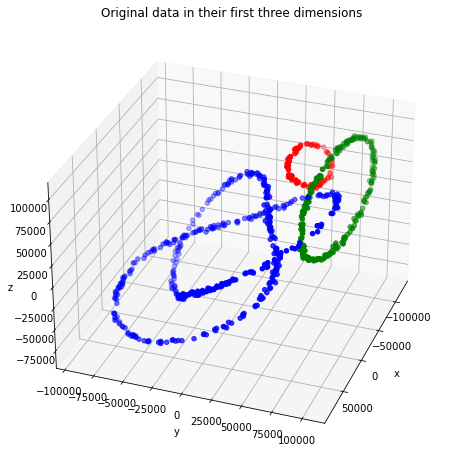

In [7]:
plot_dim(data, i=0, j=1, k=2, frac1=perc0, frac2=perc1, angle1=30, angle2=20)

## Data Visualization with t-SNE <a id='p11'></a>
In this section we use t-SNE, that is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results: for this reason, we use both a random and a PCA initialization and look at the different results. We try the 2D version and the 3D version too.
Moreover, we use 4 different values of perplexities and some different values of learning_rate.
Larger perplexities lead to more nearest neighbors and less sensitive to small structure. Conversely a lower perplexity considers a smaller number of neighbors, and thus ignores more global information in favour of the local neighborhood. As far as the learning rate, if it is too low gradient descent will get stuck in a bad local minimum. If it is too high the KL divergence will increase during optimization.

### 2D t-SNE with random initialization <a id='2dtsna'></a>

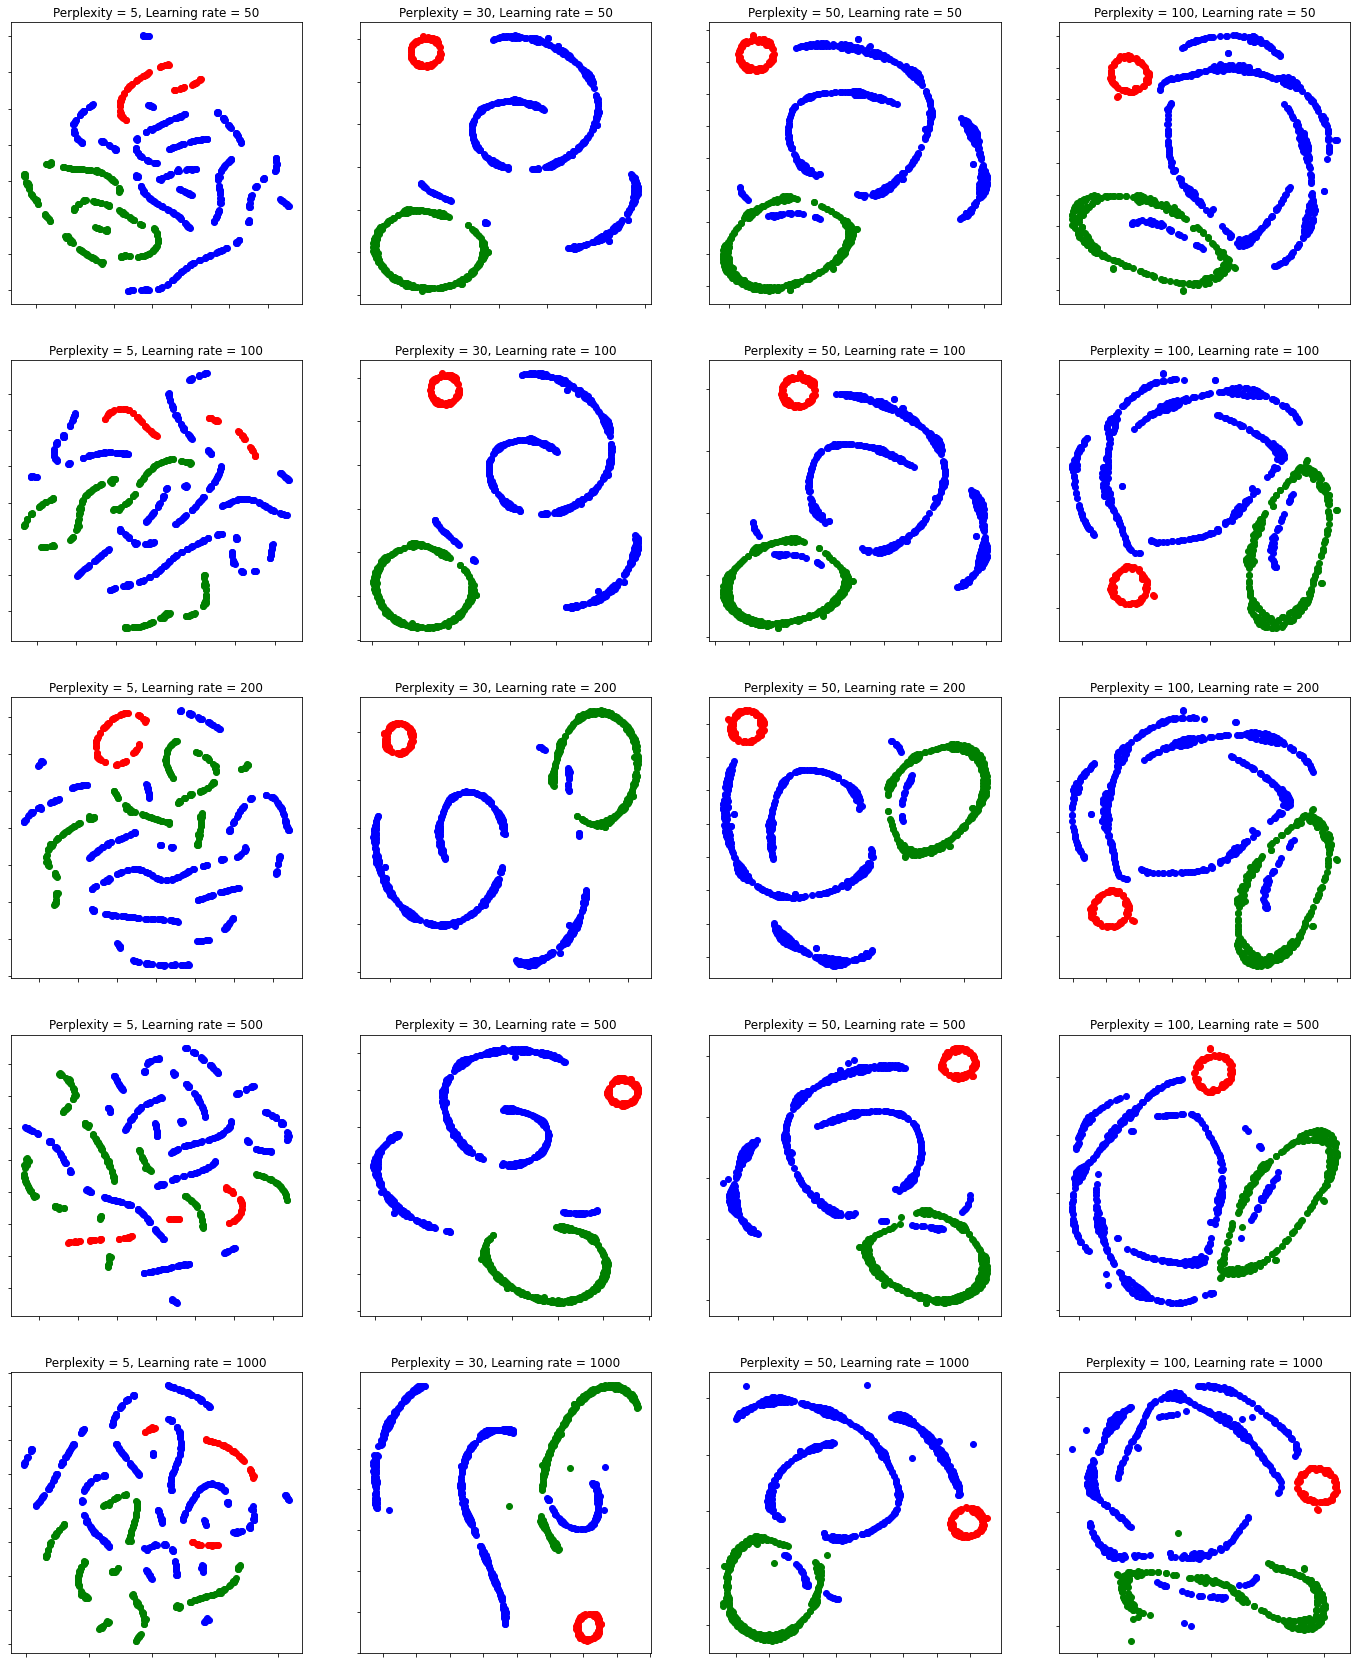

In [8]:
n_components = 2
perplexities = [5, 30, 50, 100]
learning_rates = [50, 100, 200, 500, 1000]
nr = len(learning_rates)
nc = len(perplexities)

# Plotting initialization
(fig, subplots) = plt.subplots(nr, nc, figsize=(6*nc, 6*nr))

# Plotting and fitting
for j, l in enumerate(learning_rates):
    for i, perplexity in enumerate(perplexities):
        ax = subplots[j][i]
        if use_colab:
            Y_filename = f"../content/drive/MyDrive/lcpb/ex4/data_plot/Y_l{l}_p{perplexity}_random.npy"
        else:
            Y_filename = f"data_plot/Y_l{l}_p{perplexity}_random.npy"
        if not os.path.isfile(Y_filename):
            t0 = time()
            tsne = TSNE(
                n_components=n_components, init='random',
                n_iter=1000, random_state=0, perplexity=perplexity,
                learning_rate=l, n_jobs=-1
            )
            Y = tsne.fit_transform(data)
            t1 = time()
            np.save(Y_filename, Y)
            print(f"learning rate = {l}, perplexity = {perplexity} in {t1-t0:.2g} sec")
        else:
            Y = np.load(Y_filename)
        ax.set_title(f"Perplexity = {perplexity}, Learning rate = {l}")
        ax.scatter(Y[red, 0], Y[red, 1], c="r")
        ax.scatter(Y[green, 0], Y[green, 1], c="g")
        ax.scatter(Y[blue, 0], Y[blue, 1], c="b")
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

### 2D t-SNE with PCA initialization <a id='2dtsnepca'></a>

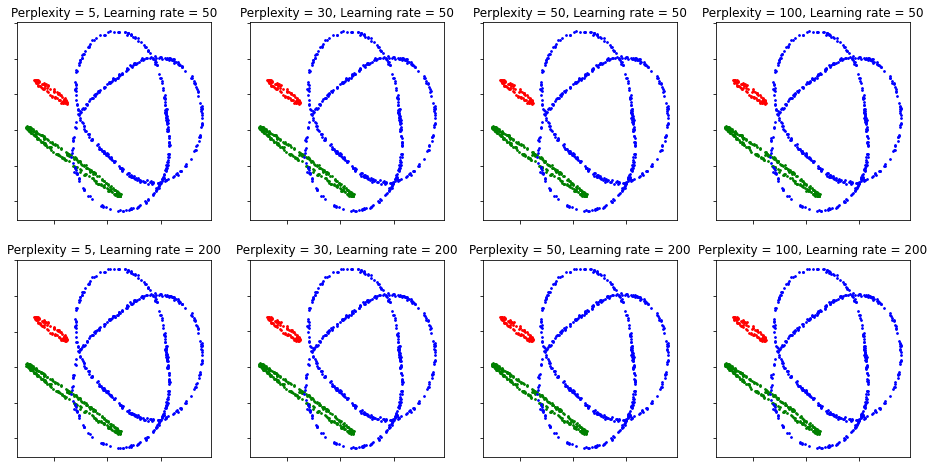

In [9]:
n_components = 2

perplexities = [5, 30, 50, 100]
learning_rates = [50, 200]
nr = len(learning_rates)
nc = len(perplexities)


# Plotting initialization
(fig, subplots) = plt.subplots(nr, nc, figsize=(4*nc, 4*nr))

# Plotting and fitting
for j, l in enumerate(learning_rates):
    for i, perplexity in enumerate(perplexities):
        ax = subplots[j][i]
        if use_colab:
            Y_filename = f"../content/drive/MyDrive/lcpb/ex4/data_plot/Y_l{l}_p{perplexity}_pca.npy"
        else:
            Y_filename = f"data_plot/Y_l{l}_p{perplexity}_pca.npy"
        if not os.path.isfile(Y_filename):
            t0 = time()
            tsne = TSNE(
                n_components=n_components, init='pca',
                n_iter=1000, random_state=0, perplexity=perplexity,
                learning_rate=l, n_jobs=-1
            )
            Y = tsne.fit_transform(data)
            t1 = time()
            np.save(Y_filename, Y)
            print(f"learning rate = {l}, perplexity = {perplexity} in {t1-t0:.2g} sec")
        else:
            Y = np.load(Y_filename)
        ax.set_title(f"Perplexity = {perplexity}, Learning rate = {l}")
        ax.scatter(Y[red, 0], Y[red, 1], c="r", s=3)
        ax.scatter(Y[green, 0], Y[green, 1], c="g", s=3)
        ax.scatter(Y[blue, 0], Y[blue, 1], c="b", s=3)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

### 3D t-SNE with random initialization <a id='3d'></a>

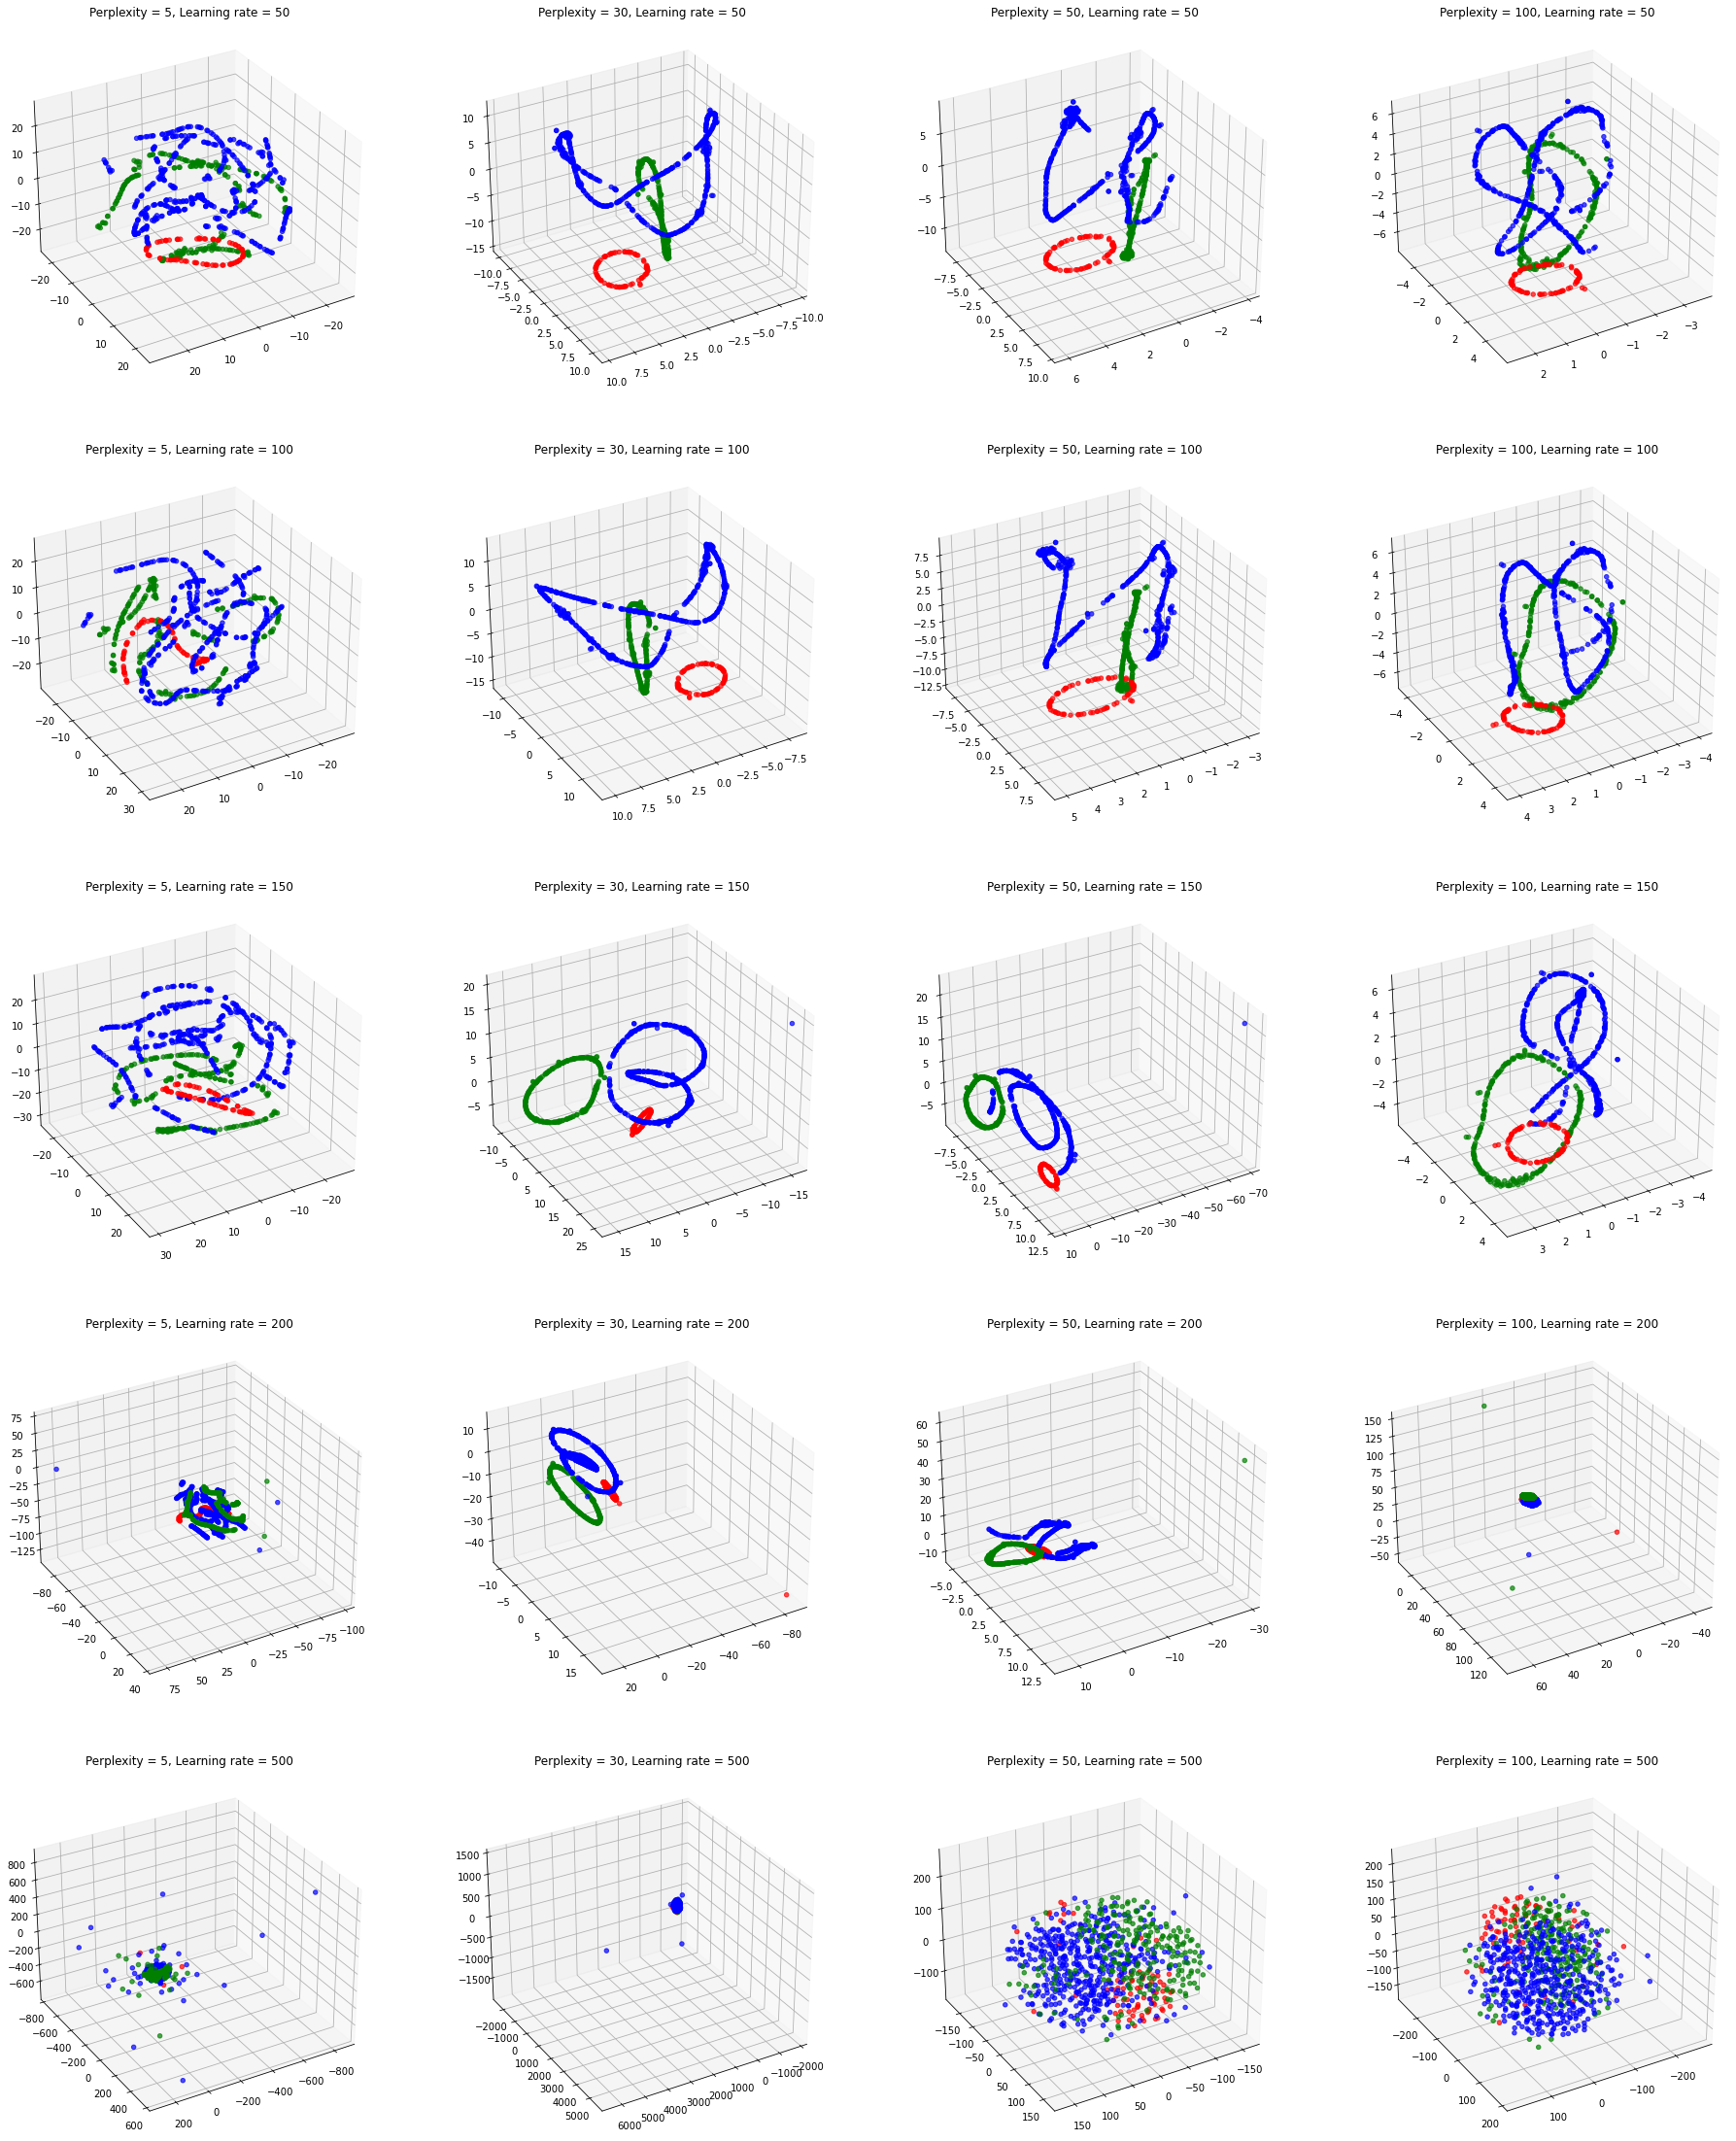

In [10]:
n_components = 3

perplexities = [5, 30, 50, 100]
learning_rates = [50, 100, 150, 200, 500]
nr = len(learning_rates)
nc = len(perplexities)

# Plotting initialization
nr, nc = len(learning_rates), len(perplexities)
fig = plt.figure(figsize=(8*nc, 8*nr))

# Plotting and fitting
for j, l in enumerate(learning_rates):
    for i, perplexity in enumerate(perplexities):
        ax = fig.add_subplot(nr, nc, j*nc+i+1, projection='3d')
        if use_colab:
            Y_filename = f"../content/drive/MyDrive/lcpb/ex4/data_plot/Y_l{l}_p{perplexity}_random_components{n_components}_3D.npy"
        else:
            Y_filename = f"data_plot/Y_l{l}_p{perplexity}_random_components{n_components}_3D.npy"
        if not os.path.isfile(Y_filename):
            t0 = time()
            tsne = TSNE(
                n_components=n_components, init='random',
                n_iter=1000, random_state=0, perplexity=perplexity,
                learning_rate=l, n_jobs=-1
            )
            Y = tsne.fit_transform(data)
            t1 = time()
            np.save(Y_filename, Y)
            print(f"learning rate = {l}, perplexity = {perplexity} in {t1-t0:.2g} sec")
        else:
            Y = np.load(Y_filename)
        
        x = Y[:,0]
        y = Y[:,1]
        z = Y[:,2]
        
        N  = len(x)
        N1 = int(N*perc0)
        N2 = int(N*perc1)
        N3 = int(N*(1-perc0-perc1))
        
        x1 = x[:N1]
        x2 = x[N1:(N1+N2)]
        x3 = x[(N1+N2):]
        y1 = y[:N1]
        y2 = y[N1:(N1+N2)]
        y3 = y[(N1+N2):]
        z1 = z[:N1]
        z2 = z[N1:(N1+N2)]
        z3 = z[(N1+N2):]
        
        ax.set_title(f"Perplexity = {perplexity}, Learning rate = {l}")
        ax.scatter(x1, y1, z1, c="r", alpha=0.7)
        ax.scatter(x2, y2, z2, c="g", alpha=0.7)
        ax.scatter(x3, y3, z3, c="b", alpha=0.7)
        ax.view_init(30, 60)

## 3D t-SNE with PCA initialization <a id='3dpca'></a>

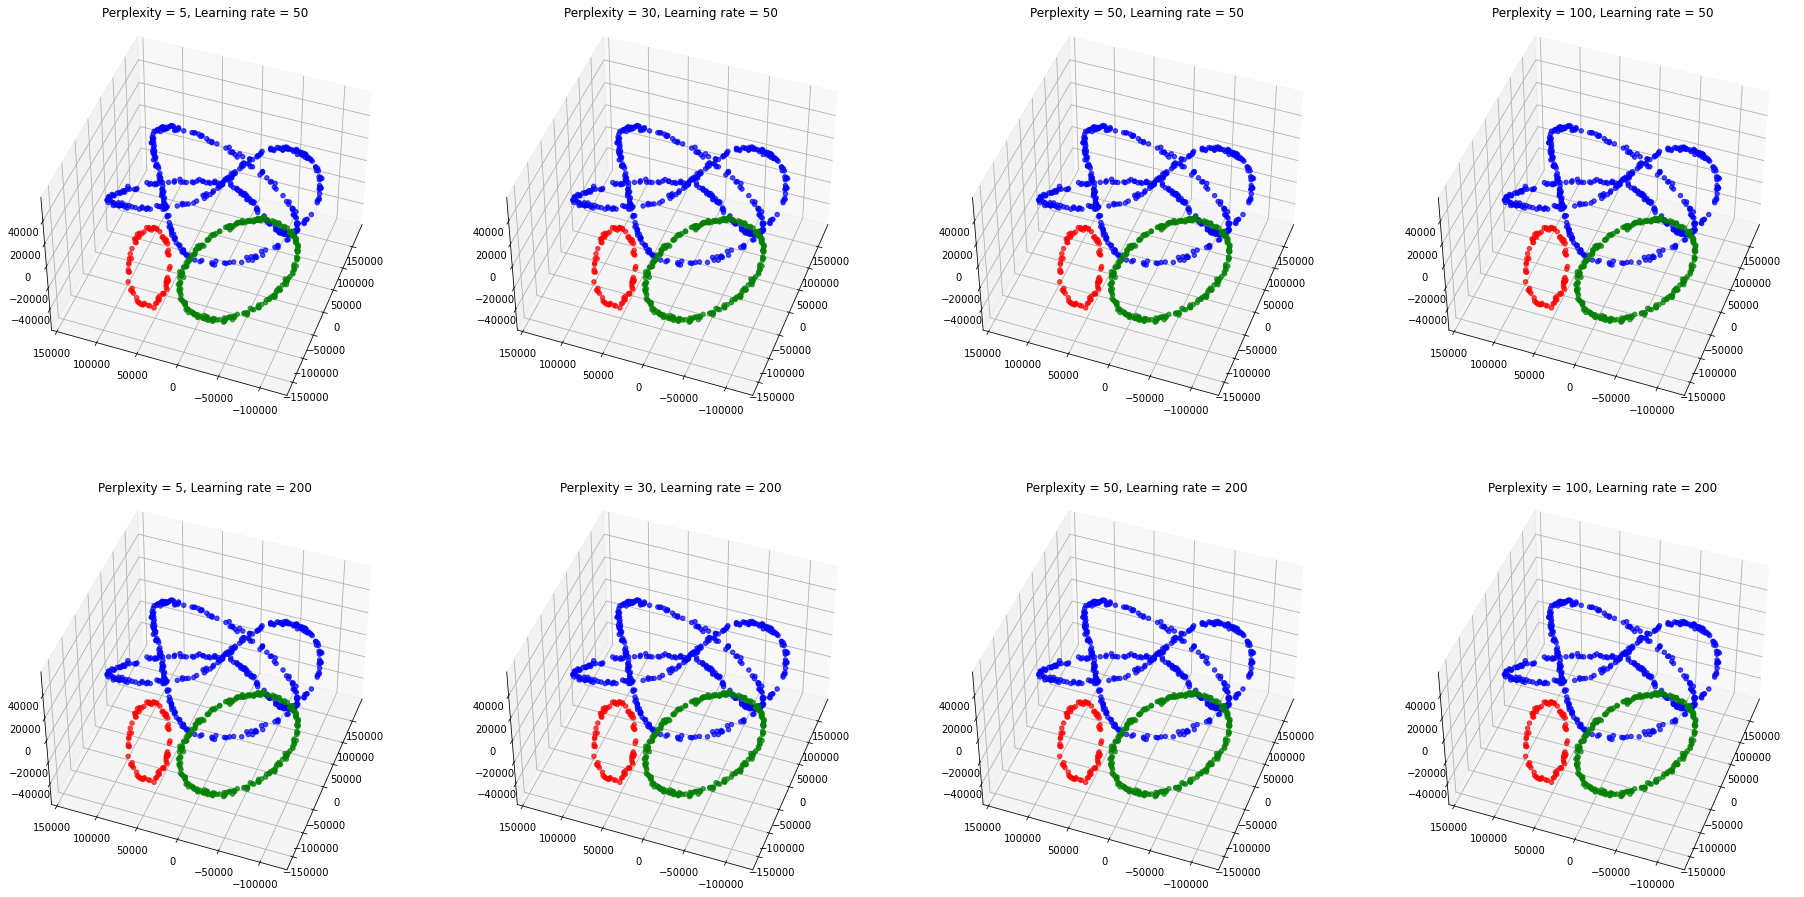

In [11]:
n_components = 3

perplexities = [5, 30, 50, 100]
learning_rates = [50, 200]
nr = len(learning_rates)
nc = len(perplexities)

# Plotting initialization
nr, nc = len(learning_rates), len(perplexities)
fig = plt.figure(figsize=(8*nc, 8*nr))

# Plotting and fitting
for j, l in enumerate(learning_rates):
    for i, perplexity in enumerate(perplexities):
        ax = fig.add_subplot(nr, nc, j*nc+i+1, projection='3d')
        if use_colab:
            Y_filename = f"../content/drive/MyDrive/lcpb/ex4/data_plot/Y_l{l}_p{perplexity}_pca_components{n_components}_3D.npy"
        else:
            Y_filename = f"data_plot/Y_l{l}_p{perplexity}_pca_components{n_components}_3D.npy"
        if not os.path.isfile(Y_filename):
            t0 = time()
            tsne = TSNE(
                n_components=n_components, init='pca',
                n_iter=1000, perplexity=perplexity,
                learning_rate=l, n_jobs=-1
            )
            Y = tsne.fit_transform(data)
            t1 = time()
            np.save(Y_filename, Y)
            print(f"learning rate = {l}, perplexity = {perplexity} in {t1-t0:.2g} sec")
        else:
            Y = np.load(Y_filename)
        
        x = Y[:,0]
        y = Y[:,1]
        z = Y[:,2]
        
        N  = len(x)
        N1 = int(N*perc0)
        N2 = int(N*perc1)
        N3 = int(N*(1-perc0-perc1))
        
        x1 = x[:N1]
        x2 = x[N1:(N1+N2)]
        x3 = x[(N1+N2):]
        y1 = y[:N1]
        y2 = y[N1:(N1+N2)]
        y3 = y[(N1+N2):]
        z1 = z[:N1]
        z2 = z[N1:(N1+N2)]
        z3 = z[(N1+N2):]
        
        ax.set_title(f"Perplexity = {perplexity}, Learning rate = {l}")
        ax.scatter(x1, y1, z1, c="r", alpha=0.7)
        ax.scatter(x2, y2, z2, c="g", alpha=0.7)
        ax.scatter(x3, y3, z3, c="b", alpha=0.7)
        ax.view_init(45, 200)

As we can check from the previous plots, when using the random initialization, the results are dependent both on the learning rate and the perplexity: as expected, when the learning rate is too high, the data look like a ‘ball’ with any point approximately equidistant from its nearest neighbours; we can also state that in our case a perplexity equal to 5 is too low, as our dataset sizes are large.
As far as the case with pca initialization, the results depend neither on the learnig rate nor the perplexity.

## DBSCAN <a id='p13'></a>
The DBSCAN algorithm views clusters as areas of high density separated by areas of low density.
The parameter "eps" is crucial to choose appropriately for the data set and distance function and usually cannot be left at the default value. It controls the local neighborhood of the points. When chosen too small, most data will not be clustered at all (and labeled as -1 for “noise”). When chosen too large, it causes close clusters to be merged into one cluster, and eventually the entire data set to be returned as a single cluster. For this reason, we first of all have to understand a good range for the cutoffs “eps” in DBSCAN. That's why we sort all minimum distances to first neighbors and plot them. Then, we use the minimum distance as a reference for “eps”, trying some multiples of that value.

In [12]:
from collections import OrderedDict

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)


cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6",
            "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693",
            "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", 
            "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", 
            "#00FECF", "#B05B6F"]

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

### We sort all minimum distances to first neighbors to have an idea of _eps_ range

Min distance = 0.0113, Max distance = 0.2275
Mean distance = 0.0578


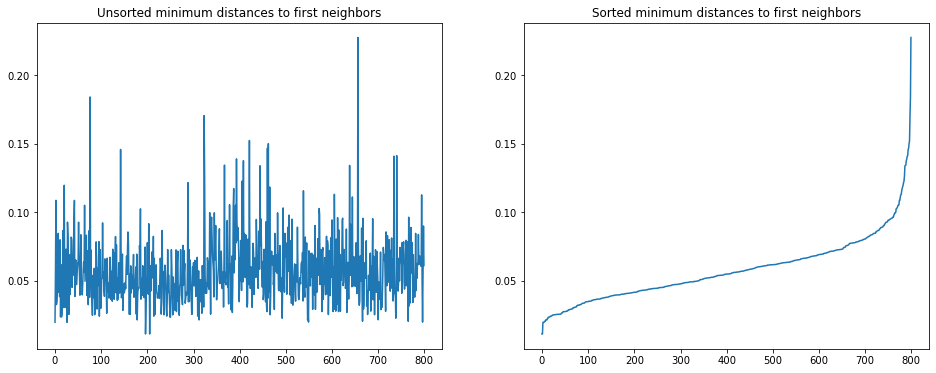

In [13]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(data)

distances = np.zeros(X.shape[0])

for i in range(X.shape[0]):
    dist_temp = np.sqrt( np.power(X[i,:]-X, 2).sum(axis=1) )
    distances[i] = np.sort(dist_temp)[1] # the first is the point itself

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].plot(distances)
ax[0].set_title("Unsorted minimum distances to first neighbors")

distances_sorted = np.sort(distances)
ax[1].plot(distances_sorted)
ax[1].set_title("Sorted minimum distances to first neighbors")

print(f"Min distance = {distances_sorted[0]:.4f}, Max distance = {distances_sorted[-1]:.4f}")
print(f"Mean distance = {distances.mean():.4f}")

### We try some multiples of the minimum distance to first neighbor for the "eps" value

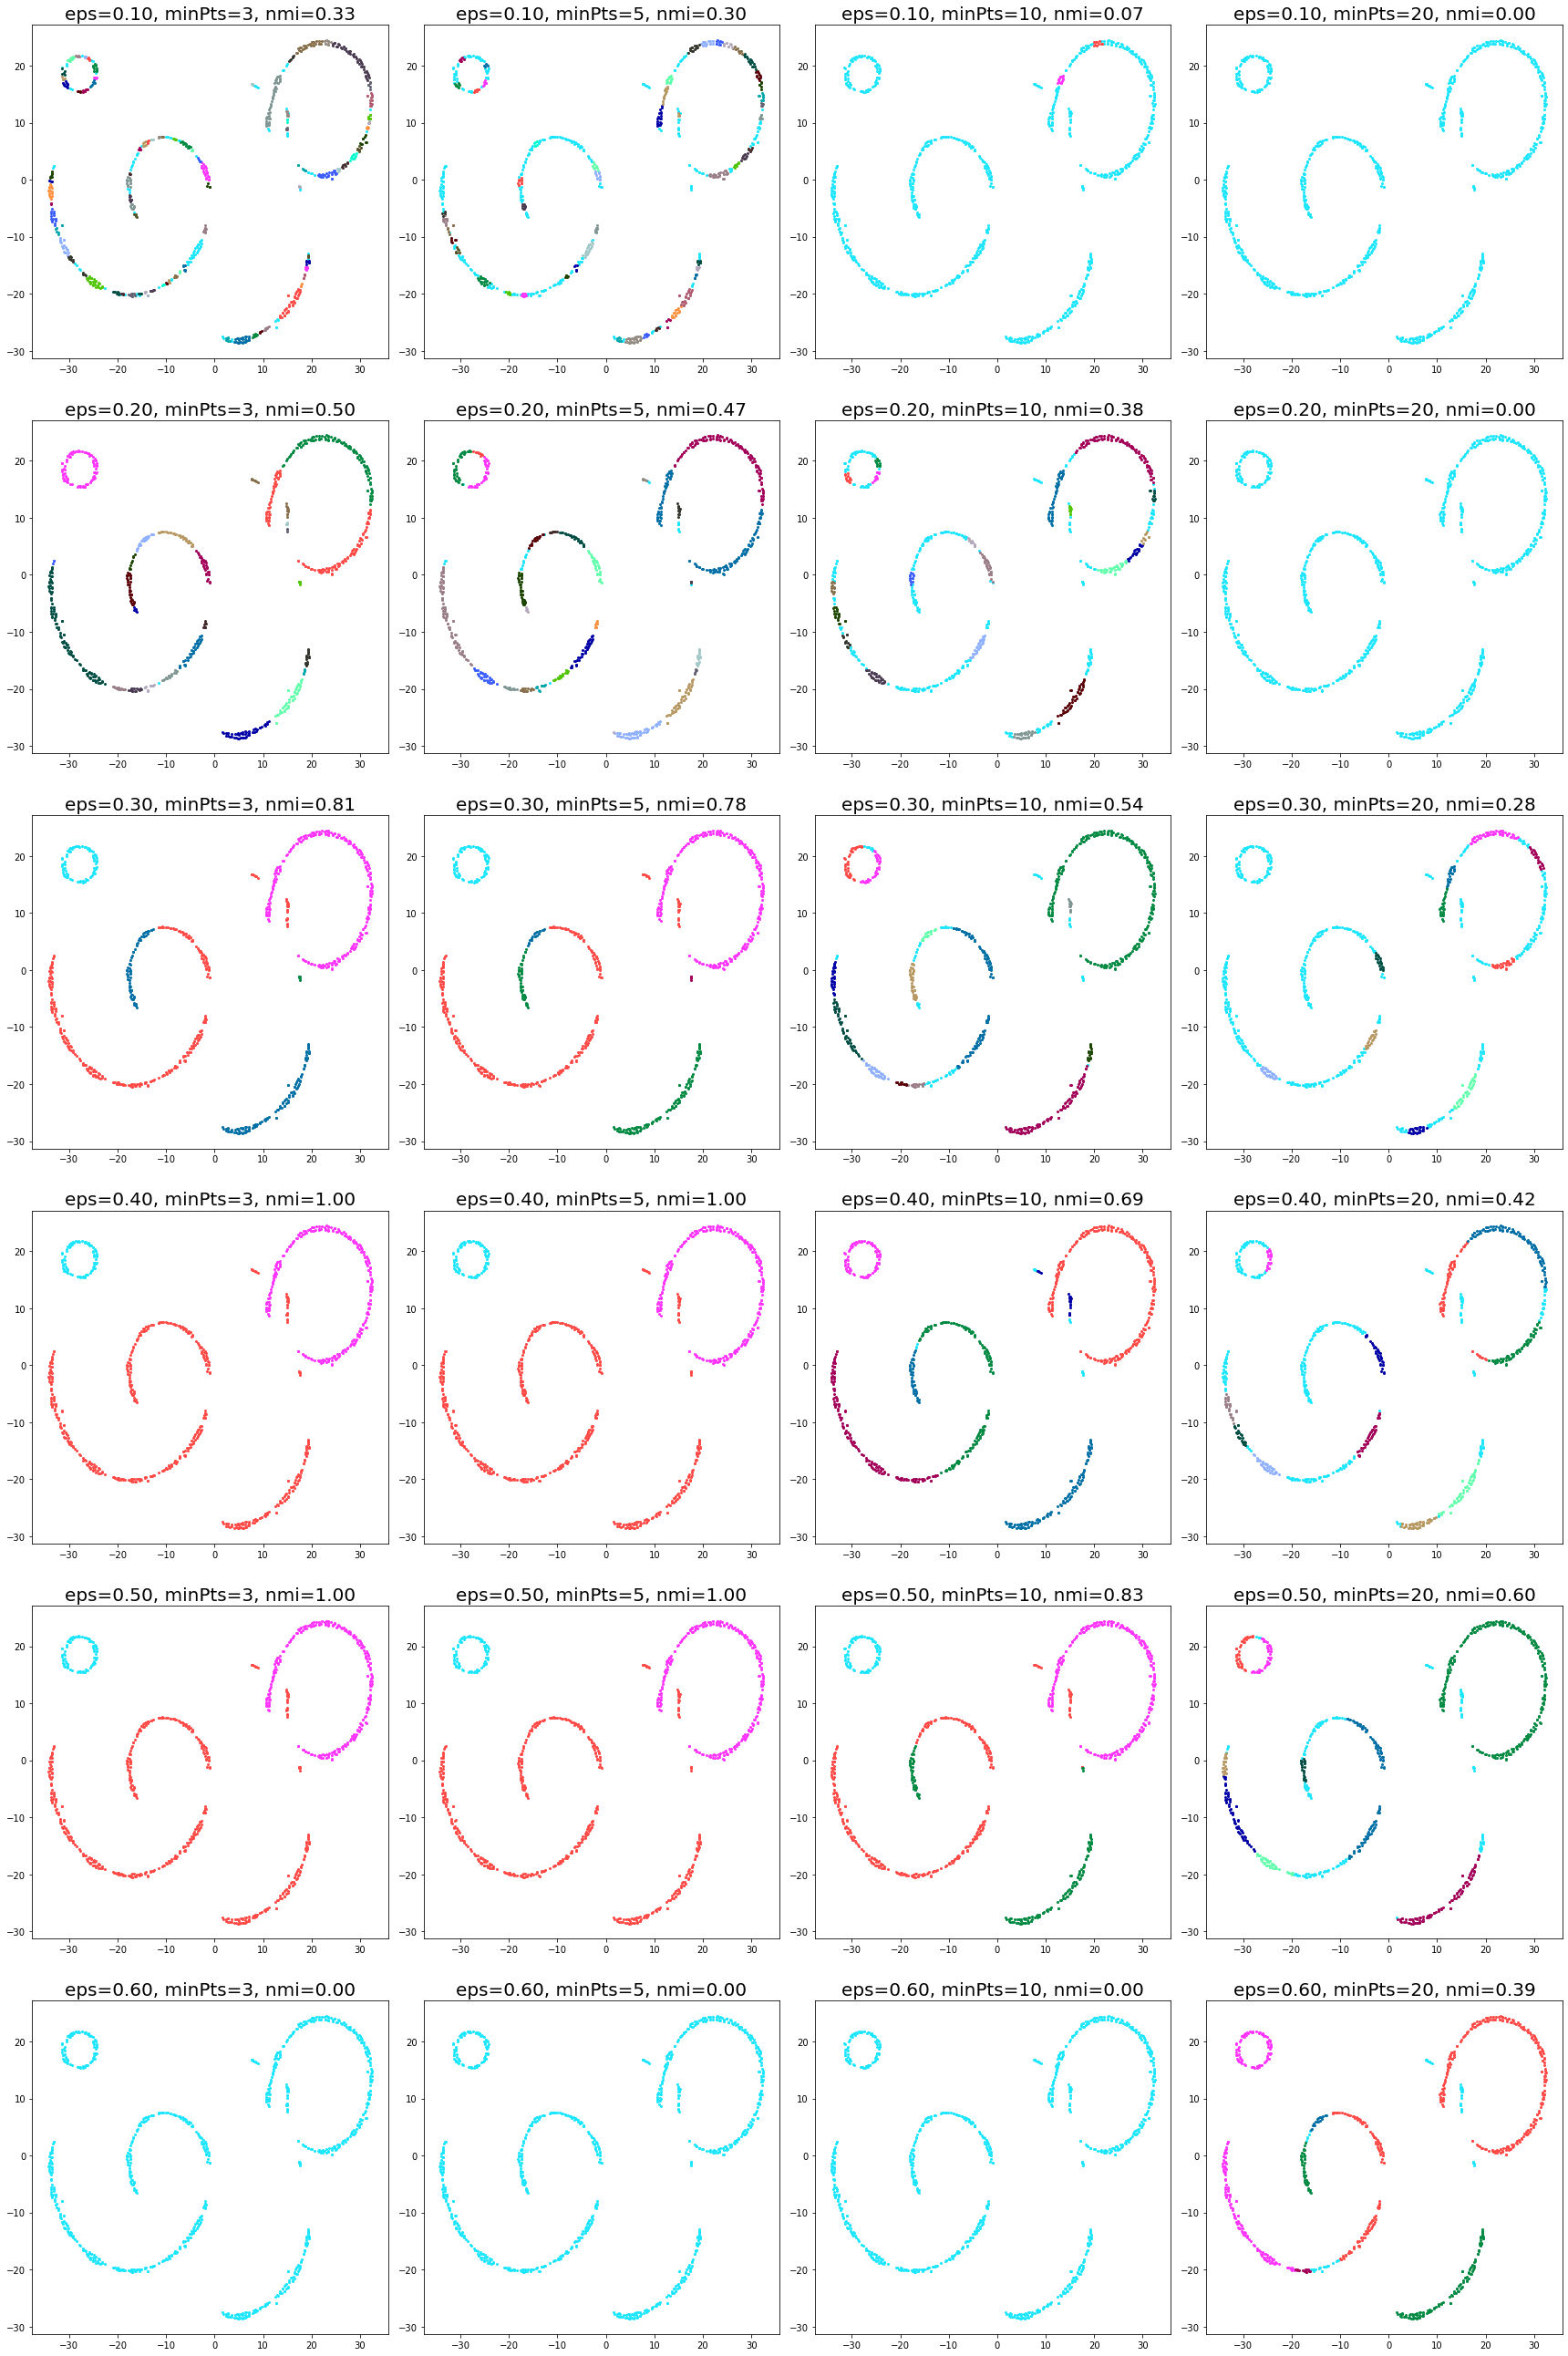

In [14]:
from sklearn.cluster import DBSCAN

l = 200
perplexity = 30

if use_colab:
    Y_filename = f"../content/drive/MyDrive/lcpb/ex4/data_plot/Y_l{l}_p{perplexity}_random.npy"
else:
    Y_filename = f"data_plot/Y_l{l}_p{perplexity}_random.npy"
y_tsne = np.load(Y_filename)

eps_range = [0.01 * x * 10 for x in range(1, 7)]
min_sample_range = [3, 5, 10, 20]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(6*len(min_sample_range),6*len(eps_range)))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        model.fit(X)
        y_fit = model.labels_
        plotting_ax(y_tsne, y_fit, ax[i,j])
        nmi = NMI(labels, y_fit)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi), fontsize=20)
plt.tight_layout(h_pad=3)
plt.show()

We can appreciate best results if eps assumes the values 0.4 or 0.5, while minPts is equals to 3 or 5.
We standardized data values for computational purposes.

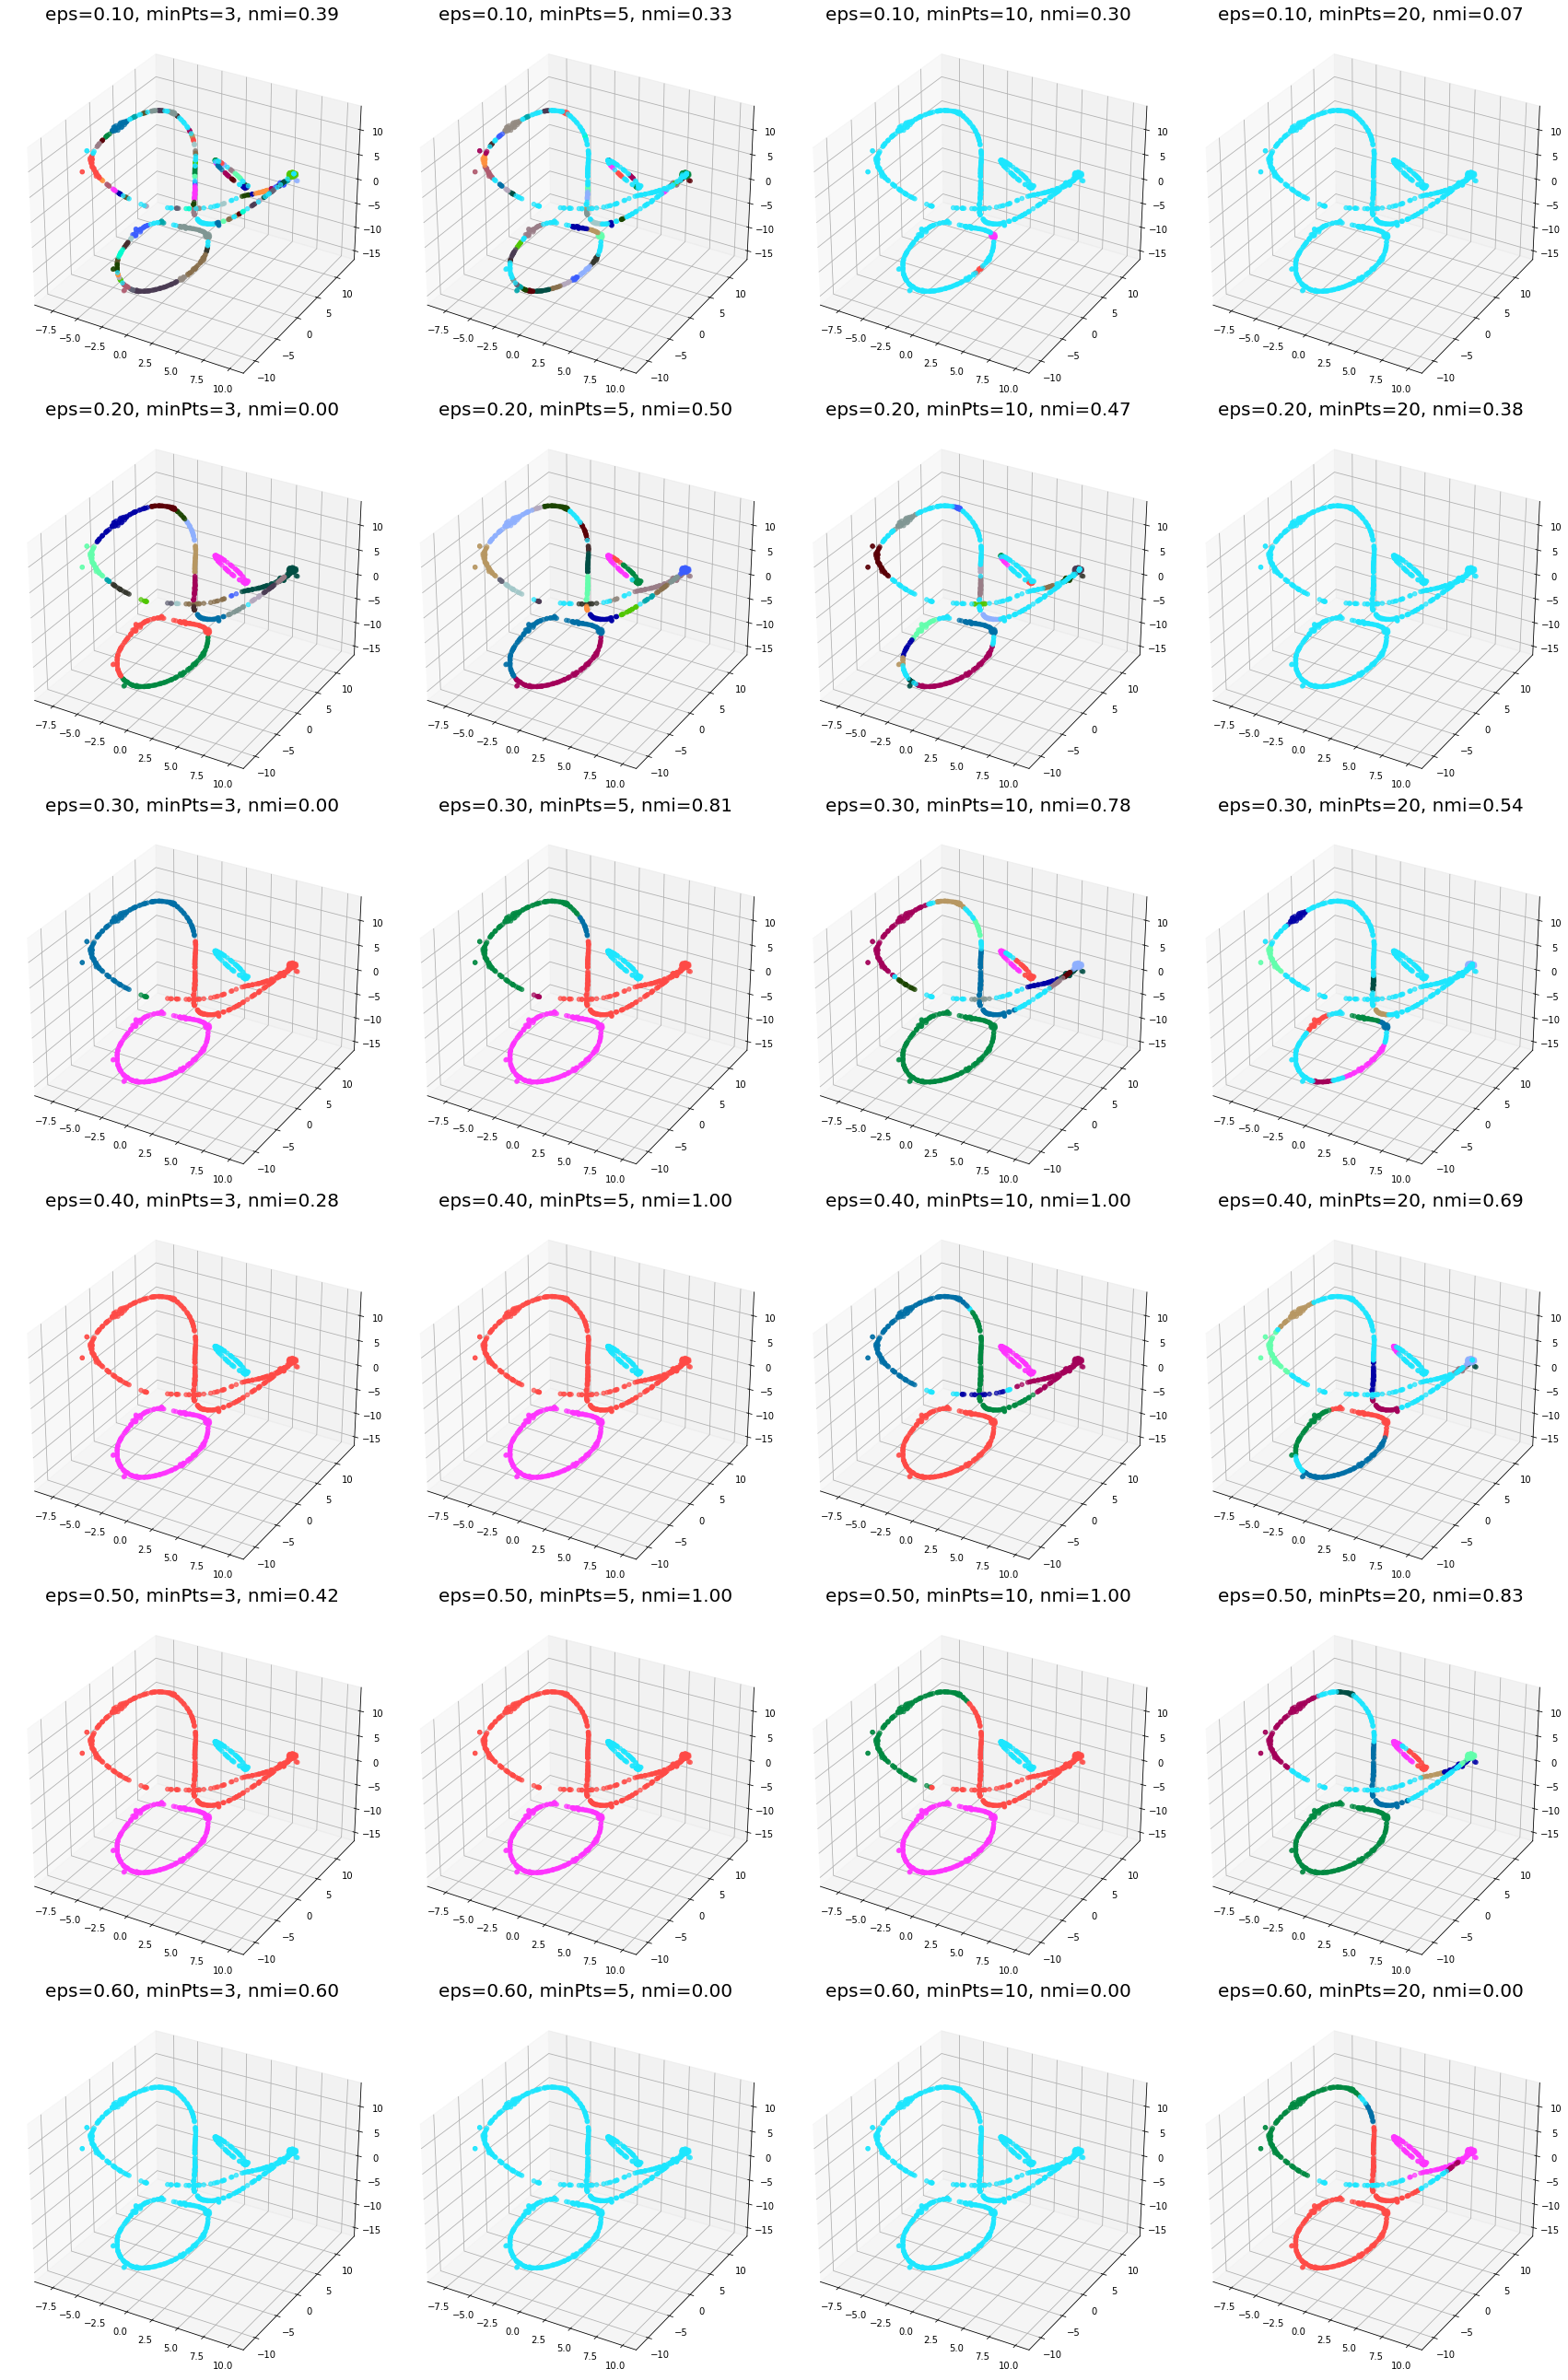

In [15]:
from sklearn.cluster import DBSCAN

cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6",
            "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693",
            "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", 
            "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", 
            "#00FECF", "#B05B6F"]
l = 100
perplexity = 30

if use_colab:
    Y_filename = f"../content/drive/MyDrive/lcpb/ex4/data_plot/Y_l{l}_p{perplexity}_random_components{n_components}_3D.npy"
else:
    Y_filename = f"data_plot/Y_l{l}_p{perplexity}_random_components{n_components}_3D.npy"

y_tsne = np.load(Y_filename)

eps_range = [0.01 * x * 10 for x in range(1, 7)]
min_sample_range = [3, 5, 10, 20]

nr = len(eps_range)
nc = len(min_sample_range)

# Plotting initialization
nr, nc = len(eps_range), len(min_sample_range)
fig = plt.figure(figsize=(6*nc, 6*nr))

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        model.fit(X)
        y_fit = model.labels_
        
        mask_l=[]  
        label_num=np.unique(y_fit)
        label_num=np.sort(label_num)
        for l in label_num:
            mask_l.append(y_fit==l)
            
        ax = fig.add_subplot(nr, nc, i*nc+j+1, projection='3d')
        
        for k in range(len(mask_l)):
            ax.scatter(
                y_tsne[:,0][mask_l[k]], y_tsne[:,1][mask_l[k]], y_tsne[:,2][mask_l[k]],
                c = cpalette[k%30], alpha=0.7)

        ax.set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi), fontsize=20)
        
        nmi = NMI(labels, y_fit)
plt.tight_layout(h_pad=0.5)
plt.show()

#  Part 2 <a id='p2'></a>

In this second part we repeat the t-SNE and DBSCAN analysis for the data generated with the notebook
“exe04_1-generate.ipynb”: "x_M5_N400.csv". The data are a sequences of ones and zeros to which is associated one of the five labels y=0,1,2,3,4. Each label corresponds to a specific enforced subsequence.

In the following we have associed to the labels the following colors: y=0 black, y=1 red, y=2 green, y=3 blue and y=4 yellow. Also we take into consideration the noise with the label y=-1 and the color associated is silver. 

In [11]:
if use_colab:
    filex="../content/drive/MyDrive/lcpb/ex4/DATA/x_M5_N400.csv"
    filey="../content/drive/MyDrive/lcpb/ex4/DATA/y_M5_N400.csv"
else:
    filex="DATA/x_M5_N400.csv"
    filey="DATA/y_M5_N400.csv"
data = np.loadtxt(filex, delimiter=' ', dtype=int)
label = np.loadtxt(filey, delimiter=' ', dtype=int)

Nx= len(data)

mask0=label==0
mask1=label==1
mask2=label==2
mask3=label==3
mask4=label==4

## Perform the t-SNE analysis <a id='tsne2'></a>

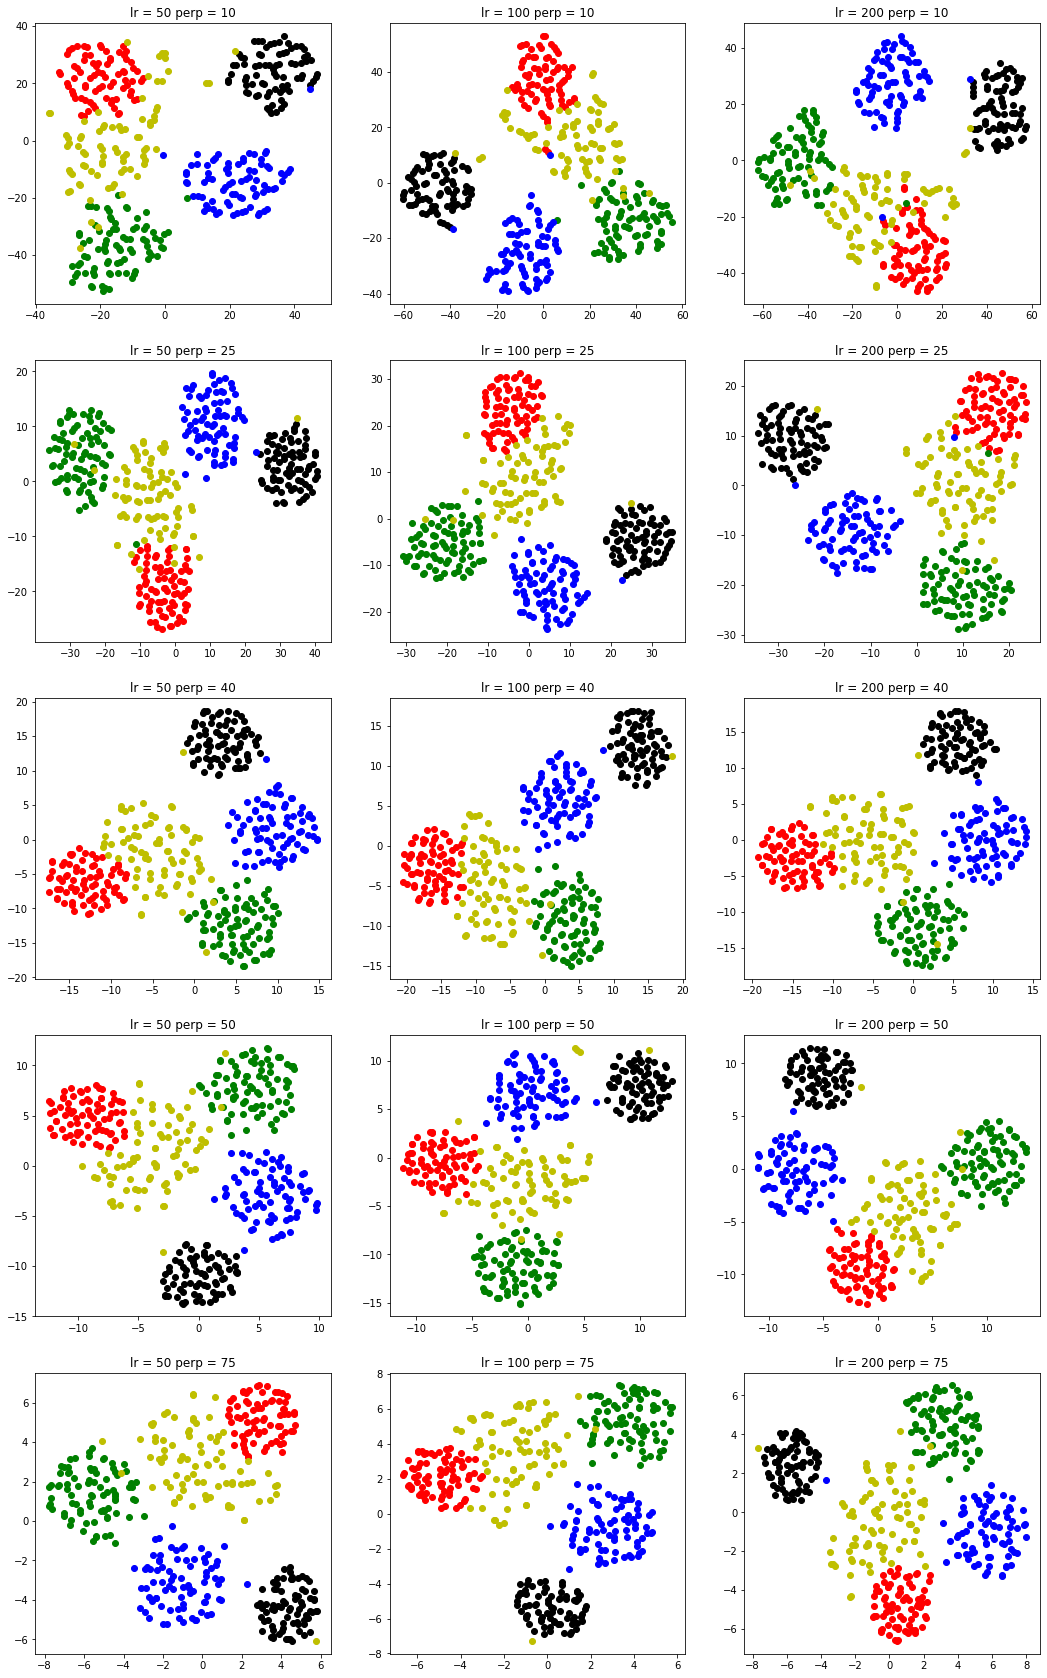

In [12]:
from sklearn import manifold, datasets
from time import time

perplexities   = [10, 25,40, 50 ,75]
learning_rates = [50,  100, 200]


n_components = 2
fig, ax = plt.subplots(len(perplexities), len(learning_rates), figsize=(6*len(learning_rates), 6*len(perplexities)))

for i in range(len(perplexities)):
    for j in range(len(learning_rates)):
        perp = perplexities[i]
        lr   = learning_rates[j]
        tsne = manifold.TSNE(n_components=n_components, init='random', perplexity=perp, 
                             learning_rate=lr, 
                             n_iter=1000, random_state=0, verbose=0, n_jobs=-1)
        data_transf = tsne.fit_transform(data)
        
        x = data_transf[:,0]
        y = data_transf[:,1]
        
        N  = len(x)
        
        x0 = x[mask0]
        x1 = x[mask1]
        x2 = x[mask2]
        x3 = x[mask3]
        x4 = x[mask4]
        
        
        y0 = y[mask0]
        y1 = y[mask1]
        y2 = y[mask2]
        y3 = y[mask3]
        y4 = y[mask4]
        
        ax[i,j].scatter(x0,y0, c='k')
        ax[i,j].scatter(x1,y1, c='r')
        ax[i,j].scatter(x3,y3, c='g')
        ax[i,j].scatter(x2,y2, c='b')
        ax[i,j].scatter(x4,y4, c='y')

        ax[i,j].set_title("lr = "+str(lr)+" perp = "+str(perp))

### Why are points for y=1 (red) close to those with y=4 (yellow) in t-SNE?

In [1]:
  '''pattern(X,l0,l1):
    """ zeros in the positions of list l0,
        ones in the positions of list l1"""
        '''
#y_n[0] corresppond to the position of zeros
#y_n[1] correspond to the position of ones

y_0= [[3,4,14,16,22,25,27,32],[0,5,7,9,12,15,26,30]]
y_1= [[0,11,12,23,24,28,33],[2,4,6,25,26,30,31]] 
y_2=[[0,5,8,15,19,34],[5,9,10,15,26,29]]
y_3=[[6,7,16,24,26],[3,5,13,16,27]]
y_4=[[5,12,22,28],[4,5,30,34]]
   
#Intersections between the position of zeros and ones for y=1 wrt the others

#zeros
a=list(set(y_1[0]).intersection(y_4[0]))
b=list(set(y_1[0]).intersection(y_0[0]))
c=list(set(y_1[0]).intersection(y_2[0]))
d=list(set(y_1[0]).intersection(y_3[0]))

print("Shared positions of zeros for the label y=1 and y=0: " , b)
print("Shared positions of zeros for the label y=1 and y=2: " , c)
print("Shared positions of zeros for the label y=1 and y=3: " , d)
print("Shared positions of zeros for the label y=1 and y=4: " , a)


#ones
a0=list(set(y_1[1]).intersection(y_4[1]))
b0=list(set(y_1[1]).intersection(y_0[1]))
c0=list(set(y_1[1]).intersection(y_2[1]))
d0=list(set(y_1[1]).intersection(y_3[1]))

print("\n")
print("Shared positions of ones for the label y=1 and y=0: " , b0)
print("Shared positions of ones for the label y=1 and y=2: " , c0)
print("Shared positions of ones for the label y=1 and y=3: " , d0)
print("Shared positions of ones for the label y=1 and y=4: " , a0)
#print(len(a)+len(a0))
#print(len(b)+len(b0))
#print(len(c)+len(c0))
#print(len(d)+len(d0))




Shared positions of zeros for the label y=1 and y=0:  []
Shared positions of zeros for the label y=1 and y=2:  [0]
Shared positions of zeros for the label y=1 and y=3:  [24]
Shared positions of zeros for the label y=1 and y=4:  [12, 28]


Shared positions of ones for the label y=1 and y=0:  [26, 30]
Shared positions of ones for the label y=1 and y=2:  [26]
Shared positions of ones for the label y=1 and y=3:  []
Shared positions of ones for the label y=1 and y=4:  [4, 30]


To understeand why points for y=1 (red) are close to those with y=4 (yellow) we look at how how the data are generated. From this we can see that the label y=1 and y=4  share the highest number of equal position:  both for the zeros and the ones we have two equal positions.

## Sort all minimum distances to first neighbors and plot them <a id='neigh'></a>

Min distance = 3.0000, Max distance = 10.0000
Mean distance = 6.4625


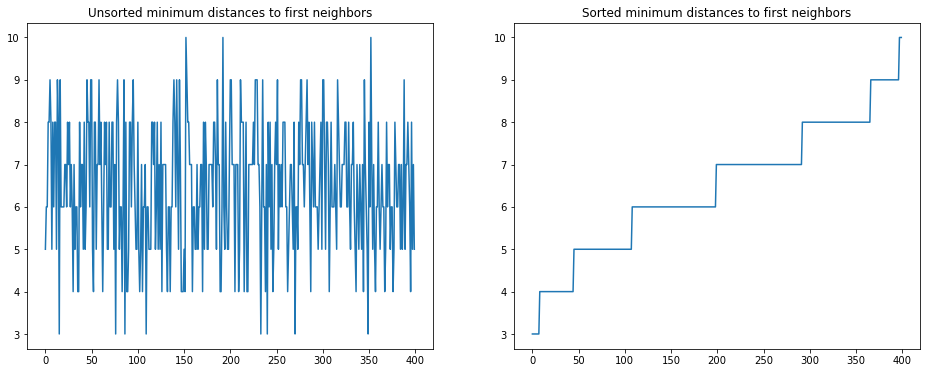

In [13]:
from sklearn.preprocessing import StandardScaler

#X = StandardScaler().fit_transform(data)
X=data
distances = np.zeros(X.shape[0])

for i in range(X.shape[0]):
    dist_temp = np.abs(X[i,:]-X).sum(axis=1)
    distances[i] = np.sort(dist_temp)[1] # the first is the point itself

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].plot(distances)
ax[0].set_title("Unsorted minimum distances to first neighbors")

distances_sorted = np.sort(distances)
ax[1].plot(distances_sorted)
ax[1].set_title("Sorted minimum distances to first neighbors")

print(f"Min distance = {distances_sorted[0]:.4f}, Max distance = {distances_sorted[-1]:.4f}")
print(f"Mean distance = {distances.mean()}")


## DBSCAN applied to the 36-dimensional bit data <a id='dbscan36'></a>



In [15]:
from collections import OrderedDict

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """
    Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c * np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,6], X[pos,29],c=cpalette[i%len(cpalette)],s=4)

        
def plot_datap2(x,y,mask_array):
    x0 = x[mask_array[0]]
    x1 = x[mask_array[1]]
    x2 = x[mask_array[2]]
    x3 = x[mask_array[3]]
    x4 = x[mask_array[4]]
    x_noise=x[mask_array[5]]

    y_noise=y[mask_array[5]]          
    y0 = y[mask_array[0]]
    y1 = y[mask_array[1]]
    y2 = y[mask_array[2]]
    y3 = y[mask_array[3]]
    y4 = y[mask_array[4]]

    plt.figure()
    plt.scatter(x1,y1, c='r')
    plt.scatter(x3,y3, c='g')
    plt.scatter(x2,y2, c='b')
    plt.scatter(x0,y0, c='black')
    plt.scatter(x4,y4, c='y')
    plt.scatter(x_noise,y_noise, c='silver')

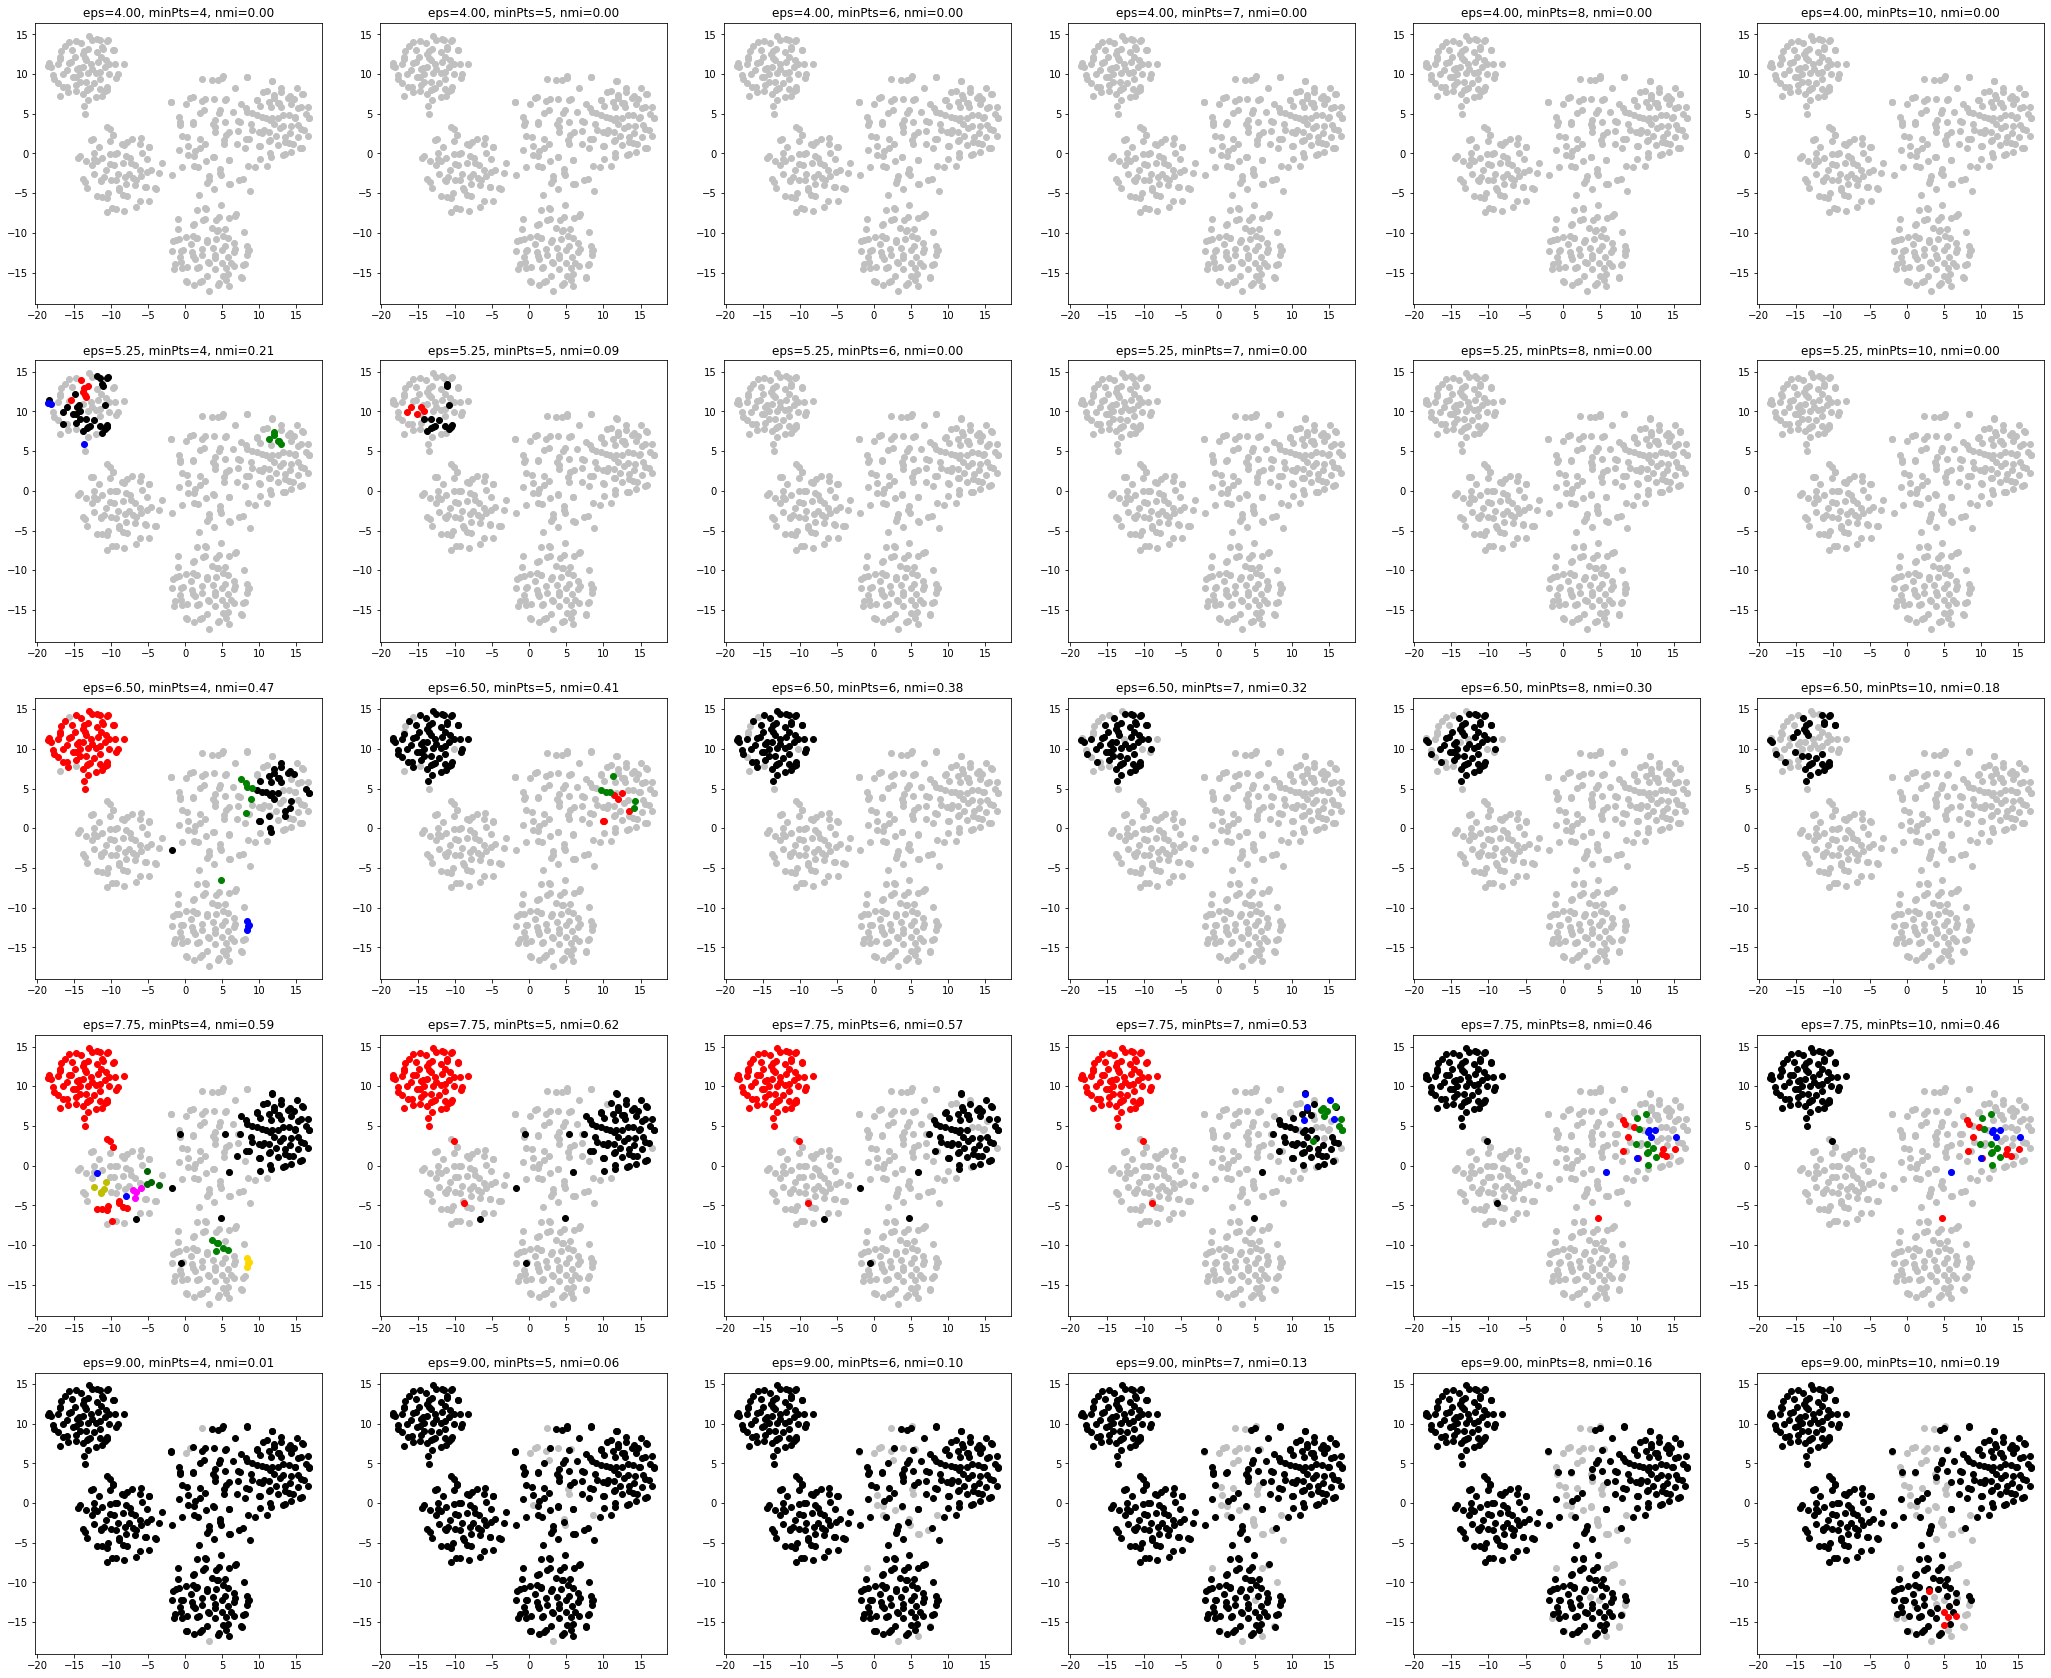

In [17]:
epss  = [x for x in np.linspace(4.0,9 ,5)]
minsp = [x for x in np.linspace(4,10 ,6)]

cpalette = ["silver","k", "r", "g", "b", "y", "magenta", "gold", "darkgreen", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF"]

def plot_datap3(x,y,mask_array,ax):
    for i in range(mask_array.shape[0]):
        ax.scatter(x[mask_array[i]], y[mask_array[i]],c=cpalette[i%len(cpalette)])


fig, ax = plt.subplots(len(epss),len(minsp),figsize=(6*len(minsp), 6*len(epss)))
nmi_list=[]
tsne = manifold.TSNE(n_components=2, init='random', perplexity=40, early_exaggeration=10.0, learning_rate=200, n_iter=5000, random_state=0,verbose=0)
data_transf = tsne.fit_transform(data)
   
x = data_transf[:,0]
y = data_transf[:,1]

for i, eps in enumerate(epss):
    for j, min_samples in enumerate(minsp):
        mask_l=[]  
        model_loop = DBSCAN(eps=eps, min_samples=min_samples,metric='manhattan')
        model_loop.fit(data)
        labelDB = model_loop.labels_
        label_num=np.unique(labelDB)
        label_num=np.sort(label_num)
        for l in label_num:
            mask_l.append(labelDB==l)    
        plot_datap3(x ,y ,np.array(mask_l),ax[i,j])
        nmi = NMI(labelDB, label)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
        nmi_list.append([nmi, eps,min_samples])
nmi_array=np.array(nmi_list)
#print(nmi_array.shape)
#print("maximum nmi,eps,min_samples",nmi_array[nmi_array[:,0]==nmi_array.max(axis=0)[0]] )
plt.show()

### In this second example you may find that t-SNE does perform well in grouping the clusters while DBSCAN does not. What is your explanation?

In the DBSCAN the core assumption is that a relative density estimation of the data is possible, however the density estimates become unreliable for high dimensional data due to large sampling noise. [1]  As we can see in the plots the points are then mostly recognized as noise and it doesn't perform well in grouping the clusters. This problem of the DBSCAN is often called "curse of dimensionality" : when the dimensionality increases, the volume of the space increases so fast that the available data become sparse. This sparsity is problematic for any method that requires statistical significance. In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality. Also, organizing and searching data often relies on detecting areas where objects form groups with similar properties; in high dimensional data, however, all objects appear to be sparse and dissimilar in many ways, which prevents common data organization strategies from being efficient. [2]

The t-SNE uses instead a fat-tailed distribution (t-distribution) to convert distances into probability scores in low dimensions: in this way moderate distance in high-dimensional space can be modeled by larger distance in low-dimensional space. [3] 

[1] A high-bias, low-variance introduction to Machine Learning for physicists - https://arxiv.org/abs/1803.08823 <br>
[2] https://en.wikipedia.org/wiki/Curse_of_dimensionality#Distance_functions <br>
[3] https://medium.com/data-folks-indonesia/the-underlying-idea-of-t-sne-6ce4cff4f7 <br>
Useful t-SNE visual explanations  https://www.youtube.com/watch?v=NEaUSP4YerM

## DBSCAN applied to the data projected to 2D by t-SNE <a id='ds2dtsne'></a>

(24, 3)
maximum nmi,eps,min_samples [[0.82873187 1.7        6.        ]]


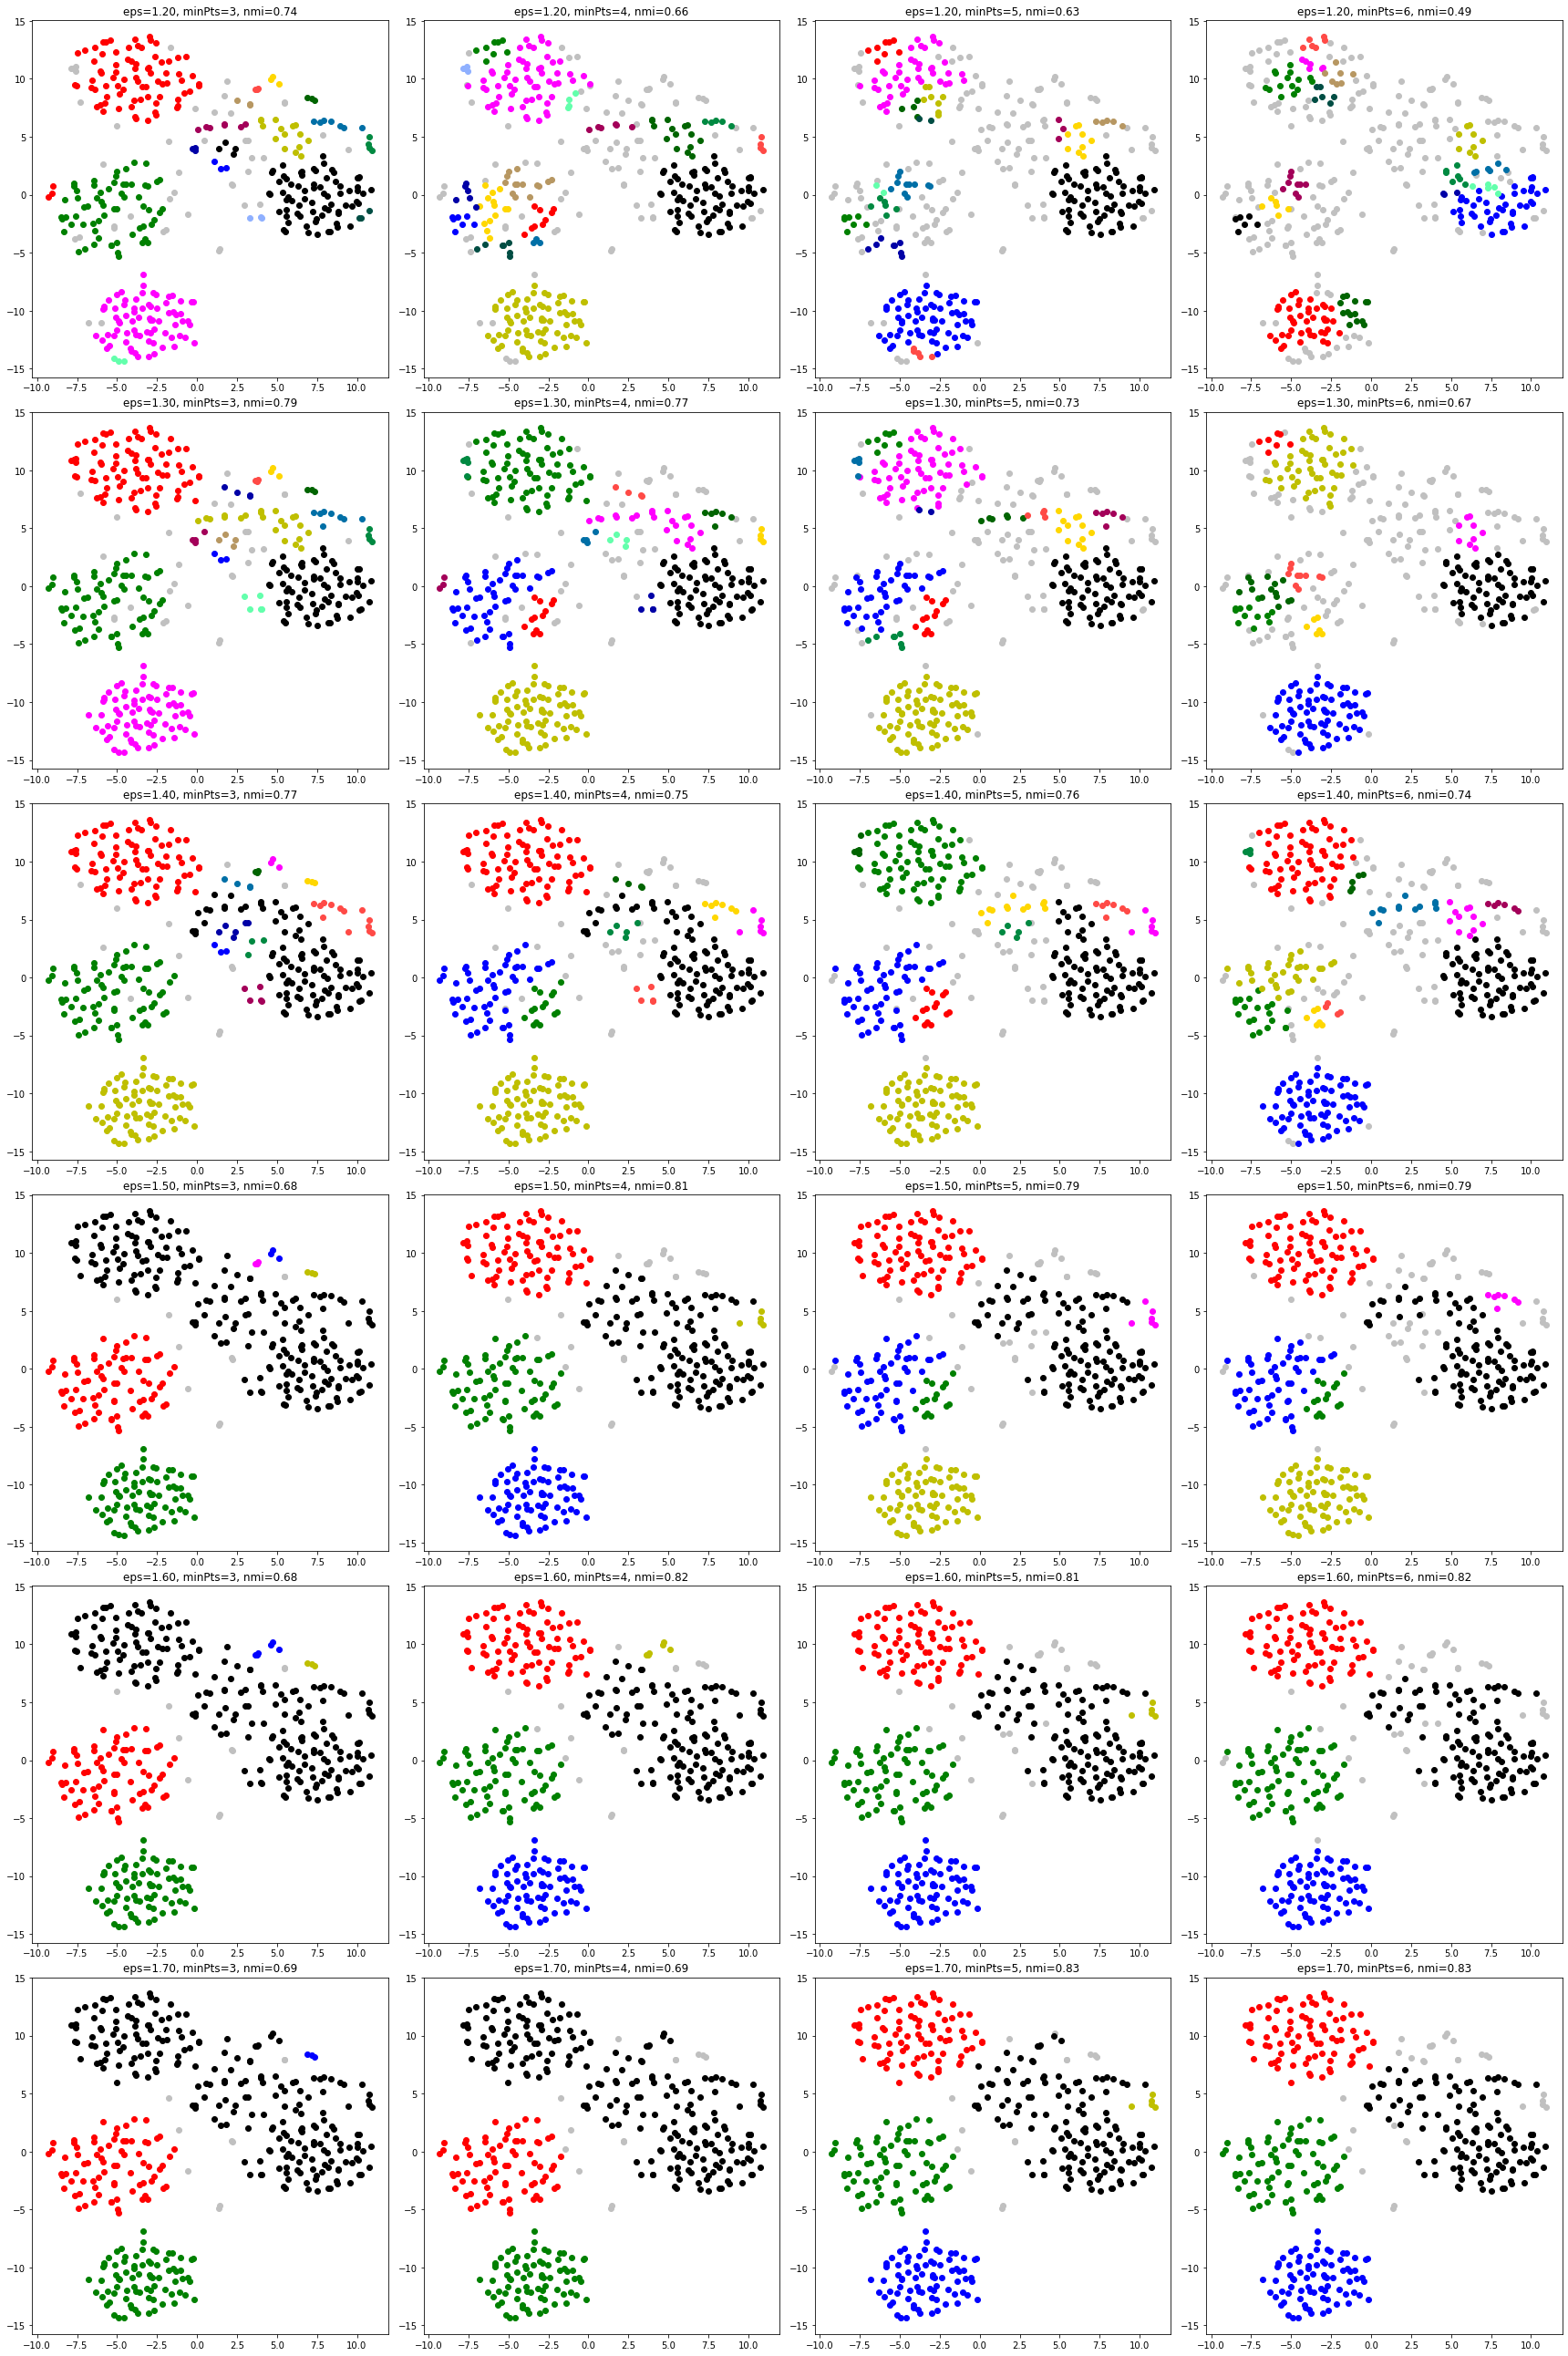

In [18]:
def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)])


lr = 200
perp = 50
X_filename = f"DATA/part2_tsne_X_l{lr}_p{perp}.npy"
Y_filename = f"DATA/part2_tsne_Y_l{lr}_p{perp}.npy"

x = np.load(X_filename)
y = np.load(Y_filename)

epss  = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
minsp = [3, 4, 5, 6]

fig, ax = plt.subplots(len(epss),len(minsp), figsize=(6*len(minsp), 6*len(epss)))

X = np.column_stack((x, y))

# X = StandardScaler().fit_transform(data)

nmi_list=[]

for i, eps in enumerate(epss):
    for j, min_samples in enumerate(minsp):
        model = DBSCAN(eps=eps, min_samples=min_samples,metric='manhattan', n_jobs=-1)
        model.fit(X)
        labelDB = model.labels_
        plotting_ax(X, labelDB, ax[i,j])
        nmi = NMI(label, labelDB)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
        nmi_list.append([nmi, eps, min_samples])
nmi_array = np.array(nmi_list)
print(nmi_array.shape)
print("maximum nmi,eps,min_samples",nmi_array[nmi_array[:,0]==nmi_array.max(axis=0)[0]] )

plt.tight_layout(h_pad=0.5)
plt.show()

As we can see from the plots the DBSCAN performs better when applied on the data projected to 2D by t-SNE.
However it still has difficulties to recognize between the labels with y=1 and y=4. As we can see, in two dimension the are not separate by a low density area.

We end up trying OPTICS algorithm, which is an extension of the DBscan. It does not use a fix density, but it try to evaluate it from each point chosen. We use it in order to see if using a fixed dimension in the previous point was the problem. As we see, also OPTICS fails, therefore we came up with the response the previous question,

In [1]:
from sklearn.cluster import OPTICS
#clustering_optics = OPTICS(min_samples=4,metric='manhattan',cluster_method='xi',p=1,max_eps=np.inf).fit(data)
#clustering_optics.labels_


minsp = [int(x) for x in np.linspace(3,6 ,3)]

cpalette = ["silver","k", "r", "g", "b", "y", "magenta", "gold", "darkgreen", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF"]

def plot_datap3(x,y,mask_array,ax):
    for i in range(mask_array.shape[0]):
        ax.scatter(x[mask_array[i]], y[mask_array[i]],c=cpalette[i%len(cpalette)])


fig, ax = plt.subplots(len(minsp),figsize=(6, 6*len(minsp)) )
nmi_list=[]
lr = 200
perp = 50
X_filename = f"DATA/part2_tsne_X_l{lr}_p{perp}.npy"
Y_filename = f"DATA/part2_tsne_Y_l{lr}_p{perp}.npy"

x = np.load(X_filename)
y = np.load(Y_filename)


for j, min_samples in enumerate(minsp):
    mask_l=[]  
    model_loop2 = OPTICS(min_samples=minsp[j],min_cluster_size=5,cluster_method='dbscan',p=1).fit(data)
    model_loop2.fit(data)
    labelDB = model_loop2.labels_
    label_num=np.unique(labelDB)
    label_num=np.sort(label_num)
    for l in label_num:
        mask_l.append(labelDB==l)    
    plot_datap3(x ,y ,np.array(mask_l),ax[j])
    nmi = NMI(labelDB, label)
    ax[j].set_title(' minPts=%i, nmi=%.2f'%(minsp[j],nmi))
    nmi_list.append([nmi,min_samples])
nmi_array=np.array(nmi_list)
#print(nmi_array.shape)
#print("maximum nmi,eps,min_samples",nmi_array[nmi_array[:,0]==nmi_array.max(axis=0)[0]] )
plt.show()

KeyboardInterrupt: 